### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_1/'
summaries_path = cur_dir + 'summaries_2_1/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 1
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        equal_weights=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 1.030077, average train accuracy: 0.545898
epoch: 2, iter: 0/8, validation accuracies: [0.5], average train loss: 1.019816, average train accuracy: 0.581055
epoch: 3, iter: 0/8, validation accuracies: [0.57499999], average train loss: 0.589316, average train accuracy: 0.700195
epoch: 4, iter: 0/8, validation accuracies: [0.40000001], average train loss: 0.631907, average train accuracy: 0.702148
epoch: 5, iter: 0/8, validation accuracies: [0.64999998], average train loss: 0.540766, average train accuracy: 0.713867
epoch: 6, iter: 0/8, validation accuracies: [0.57499999], average train loss: 0.541391, average train accuracy: 0.716797
epoch: 7, iter: 0/8, validation accuracies: [0.80000001], average train loss: 0.508858, average train accuracy: 0.748047
epoch

epoch: 66, iter: 0/8, validation accuracies: [0.875], average train loss: 0.174214, average train accuracy: 0.927734
epoch: 67, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.138371, average train accuracy: 0.942383
epoch: 68, iter: 0/8, validation accuracies: [0.92500001], average train loss: 0.122328, average train accuracy: 0.948242
epoch: 69, iter: 0/8, validation accuracies: [0.92500001], average train loss: 0.115395, average train accuracy: 0.953125
epoch: 70, iter: 0/8, validation accuracies: [0.92500001], average train loss: 0.131403, average train accuracy: 0.949219
epochs: 70.000000, final train loss: 0.120564, validation accuracies: [0.92500001]
best epochs: 34.000000, best_avg: 0.950000, validation accuracies: [0.94999999]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.38136744499206543
saving 

epoch: 51, iter: 0/8, validation accuracies: [0.80000001 0.82499999], average train loss: 0.480688, average train accuracy: 0.815430
epoch: 52, iter: 0/8, validation accuracies: [0.82499999 0.89999998], average train loss: 0.430713, average train accuracy: 0.830078
epoch: 53, iter: 0/8, validation accuracies: [0.82499999 0.89999998], average train loss: 0.409989, average train accuracy: 0.833984
epoch: 54, iter: 0/8, validation accuracies: [0.77499998 0.85000002], average train loss: 0.424791, average train accuracy: 0.839844
epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.875     ], average train loss: 0.422746, average train accuracy: 0.824219
epoch: 56, iter: 0/8, validation accuracies: [0.69999999 0.92500001], average train loss: 0.425065, average train accuracy: 0.834961
epoch: 57, iter: 0/8, validation accuracies: [0.82499999 0.85000002], average train loss: 0.446196, average train accuracy: 0.840820
epoch: 58, iter: 0/8, validation accuracies: [0.82499999 0.85000002],

epoch: 32, iter: 0/8, validation accuracies: [0.92500001 0.77499998 0.60000002], average train loss: 0.684617, average train accuracy: 0.750000
epoch: 33, iter: 0/8, validation accuracies: [0.85000002 0.64999998 0.57499999], average train loss: 0.668425, average train accuracy: 0.756836
epoch: 34, iter: 0/8, validation accuracies: [0.85000002 0.67500001 0.69999999], average train loss: 0.632996, average train accuracy: 0.763672
epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.75      ], average train loss: 0.600006, average train accuracy: 0.779297
epoch: 36, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.75      ], average train loss: 0.590393, average train accuracy: 0.781250
epoch: 37, iter: 0/8, validation accuracies: [0.94999999 0.67500001 0.52499998], average train loss: 0.630874, average train accuracy: 0.771484
epoch: 37, iter: 4/8, loss: 0.625859, accuracy: 0.789062
epoch: 38, iter: 0/8, validation accuracies: [0.5        0.75       0.72500002]

epoch: 11, iter: 0/8, validation accuracies: [0.57499999 0.60000002 0.55000001 0.75      ], average train loss: 0.758530, average train accuracy: 0.740234
epoch: 12, iter: 0/8, validation accuracies: [0.34999999 0.75       0.75       0.75      ], average train loss: 0.787804, average train accuracy: 0.731445
epoch: 12, iter: 4/8, loss: 0.790829, accuracy: 0.718750
epoch: 13, iter: 0/8, validation accuracies: [0.42500001 0.44999999 0.57499999 0.77499998], average train loss: 0.781551, average train accuracy: 0.722656
epoch: 14, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.69999999 0.75      ], average train loss: 0.721124, average train accuracy: 0.744141
epoch: 15, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.67500001 0.67500001], average train loss: 0.726146, average train accuracy: 0.742188
epoch: 16, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.67500001 0.625     ], average train loss: 0.741894, average train accuracy: 0.748047
epoch: 17, it

epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.85000002 0.77499998 0.85000002], average train loss: 0.339290, average train accuracy: 0.882812
epoch: 64, iter: 0/8, validation accuracies: [0.67500001 0.82499999 0.77499998 0.89999998], average train loss: 0.339515, average train accuracy: 0.876953
epoch: 65, iter: 0/8, validation accuracies: [0.69999999 0.85000002 0.80000001 0.85000002], average train loss: 0.327471, average train accuracy: 0.875977
epoch: 66, iter: 0/8, validation accuracies: [0.69999999 0.82499999 0.80000001 0.85000002], average train loss: 0.287433, average train accuracy: 0.897461
epoch: 67, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.77499998 0.89999998], average train loss: 0.311387, average train accuracy: 0.891602
epoch: 68, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.80000001 0.875     ], average train loss: 0.308948, average train accuracy: 0.881836
epoch: 69, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.

epoch: 37, iter: 0/8, validation accuracies: [0.375      0.85000002 0.72500002 0.89999998 0.57499999], average train loss: 0.734569, average train accuracy: 0.745117
epoch: 37, iter: 4/8, loss: 0.805240, accuracy: 0.664062
epoch: 38, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.69999999 0.85000002 0.42500001], average train loss: 0.667554, average train accuracy: 0.759766
epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.57499999 0.77499998 0.55000001], average train loss: 0.651437, average train accuracy: 0.770508
epoch: 40, iter: 0/8, validation accuracies: [0.52499998 0.89999998 0.75       0.55000001 0.77499998], average train loss: 0.625981, average train accuracy: 0.775391
epoch: 41, iter: 0/8, validation accuracies: [0.47499999 0.625      0.67500001 0.69999999 0.44999999], average train loss: 0.687229, average train accuracy: 0.750977
epoch: 42, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.77499998 0.82499999 0.72500002], average tr

epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.92500001 0.5        0.69999999 0.52499998 0.5       ], average train loss: 1.107964, average train accuracy: 0.626953
epoch: 10, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.72500002 0.625      0.5        0.27500001], average train loss: 1.219574, average train accuracy: 0.566406
epoch: 11, iter: 0/8, validation accuracies: [0.375      0.625      0.69999999 0.72500002 0.57499999 0.32499999], average train loss: 1.036786, average train accuracy: 0.666992
epoch: 12, iter: 0/8, validation accuracies: [0.375      0.52499998 0.625      0.67500001 0.57499999 0.5       ], average train loss: 1.032526, average train accuracy: 0.656250
epoch: 12, iter: 4/8, loss: 1.003162, accuracy: 0.671875
epoch: 13, iter: 0/8, validation accuracies: [0.5        0.625      0.72500002 0.67500001 0.55000001 0.47499999], average train loss: 1.000813, average train accuracy: 0.672852
epoch: 14, iter: 0/8, validation accuracies: [0.5        0.

epoch: 55, iter: 0/8, validation accuracies: [0.72500002 0.875      0.75       0.80000001 0.67500001 0.75      ], average train loss: 0.532548, average train accuracy: 0.826172
epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.85000002 0.75       0.875      0.64999998 0.75      ], average train loss: 0.517098, average train accuracy: 0.823242
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.875      0.82499999 0.875      0.69999999 0.80000001], average train loss: 0.509315, average train accuracy: 0.827148
epoch: 58, iter: 0/8, validation accuracies: [0.67500001 0.875      0.77499998 0.80000001 0.67500001 0.80000001], average train loss: 0.476347, average train accuracy: 0.849609
epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.82499999 0.80000001 0.77499998 0.625      0.80000001], average train loss: 0.527772, average train accuracy: 0.815430
epoch: 60, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.82499999 0.80000001 0.67500001 0.72500002], a

epoch: 24, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.55000001 0.77499998 0.42500001 0.72500002
 0.72500002], average train loss: 0.808892, average train accuracy: 0.720703
epoch: 25, iter: 0/8, validation accuracies: [0.52499998 0.75       0.75       0.625      0.55000001 0.80000001
 0.69999999], average train loss: 0.824719, average train accuracy: 0.738281
epoch: 25, iter: 0/8, loss: 0.860713, accuracy: 0.742188
epoch: 26, iter: 0/8, validation accuracies: [0.72500002 0.875      0.57499999 0.72500002 0.40000001 0.55000001
 0.67500001], average train loss: 0.755486, average train accuracy: 0.767578
epoch: 27, iter: 0/8, validation accuracies: [0.375      0.5        0.80000001 0.82499999 0.57499999 0.64999998
 0.72500002], average train loss: 0.736799, average train accuracy: 0.757812
epoch: 28, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.67500001 0.625      0.72500002 0.75
 0.60000002], average train loss: 0.670698, average train accuracy: 0.784180
epoc

epoch: 67, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.80000001 0.85000002 0.67500001 0.82499999
 0.85000002], average train loss: 0.434525, average train accuracy: 0.848633
epoch: 68, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.80000001 0.875      0.67500001 0.80000001
 0.82499999], average train loss: 0.421154, average train accuracy: 0.855469
epoch: 69, iter: 0/8, validation accuracies: [0.625      0.72500002 0.80000001 0.875      0.67500001 0.80000001
 0.82499999], average train loss: 0.423967, average train accuracy: 0.855469
epoch: 70, iter: 0/8, validation accuracies: [0.625      0.72500002 0.80000001 0.875      0.67500001 0.77499998
 0.85000002], average train loss: 0.480386, average train accuracy: 0.834961
epochs: 70.000000, final train loss: 0.388745, validation accuracies: [0.625      0.72500002 0.80000001 0.875      0.67500001 0.77499998
 0.85000002]
best epochs: 59.000000, best_avg: 0.771429, validation accuracies: [0.57499999 0.67500001 0.85

epoch: 33, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.72500002 0.89999998 0.5        0.375
 0.80000001 0.375     ], average train loss: 0.908995, average train accuracy: 0.706055
epoch: 34, iter: 0/8, validation accuracies: [0.375      0.64999998 0.625      0.60000002 0.67500001 0.57499999
 0.82499999 0.32499999], average train loss: 0.818622, average train accuracy: 0.742188
epoch: 35, iter: 0/8, validation accuracies: [0.375      0.69999999 0.55000001 0.60000002 0.55000001 0.80000001
 0.72500002 0.32499999], average train loss: 0.846264, average train accuracy: 0.721680
epoch: 36, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.75       0.77499998 0.64999998 0.44999999
 0.75       0.34999999], average train loss: 0.818546, average train accuracy: 0.733398
epoch: 37, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.67500001 0.72500002 0.52499998 0.55000001
 0.80000001 0.5       ], average train loss: 0.812533, average train accuracy: 0.742188
epoch

time taken: %f 0.619149923324585
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.2   0.5   0.025 0.05  0.025 0.05  0.075 0.05  0.   ], average train loss: 4.409586, average train accuracy: 0.133789
epoch: 2, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.175      0.         0.175      0.40000001
 0.025      0.025      0.025     ], average train loss: 2.413847, average train accuracy: 0.258789
epoch: 3, iter: 0/8, validation accuracies: [0.30000001 

epoch: 37, iter: 4/8, loss: 0.877857, accuracy: 0.718750
epoch: 38, iter: 0/8, validation accuracies: [0.34999999 0.875      0.77499998 0.55000001 0.55000001 0.55000001
 0.875      0.22499999 0.44999999], average train loss: 0.965464, average train accuracy: 0.694336
epoch: 39, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.72500002 0.55000001 0.55000001 0.5
 0.75       0.30000001 0.34999999], average train loss: 0.913589, average train accuracy: 0.698242
epoch: 40, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.55000001 0.77499998 0.625      0.80000001
 0.72500002 0.40000001 0.40000001], average train loss: 0.856652, average train accuracy: 0.724609
epoch: 41, iter: 0/8, validation accuracies: [0.40000001 0.75       0.69999999 0.60000002 0.60000002 0.69999999
 0.85000002 0.34999999 0.40000001], average train loss: 0.854284, average train accuracy: 0.725586
epoch: 42, iter: 0/8, validation accuracies: [0.72500002 0.5        0.625      0.85000002 0.60000002 0.524

epoch: 1, iter: 0/8, validation accuracies: [0.         0.175      0.125      0.27500001 0.         0.1
 0.30000001 0.         0.         0.        ], average train loss: 5.097200, average train accuracy: 0.076172
epoch: 2, iter: 0/8, validation accuracies: [0.075      0.375      0.125      0.5        0.         0.22499999
 0.175      0.05       0.15000001 0.        ], average train loss: 2.655993, average train accuracy: 0.210938
epoch: 3, iter: 0/8, validation accuracies: [0.1        0.47499999 0.22499999 0.52499998 0.15000001 0.22499999
 0.40000001 0.175      0.22499999 0.025     ], average train loss: 2.491380, average train accuracy: 0.254883
epoch: 4, iter: 0/8, validation accuracies: [0.1        0.5        0.34999999 0.5        0.27500001 0.34999999
 0.175      0.05       0.1        0.05      ], average train loss: 2.229220, average train accuracy: 0.351562
epoch: 5, iter: 0/8, validation accuracies: [0.075      0.55000001 0.60000002 0.64999998 0.27500001 0.42500001
 0.22499999 

epoch: 37, iter: 4/8, loss: 1.129658, accuracy: 0.671875
epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.40000001 0.5        0.64999998 0.60000002 0.64999998
 0.85000002 0.40000001 0.47499999 0.27500001], average train loss: 1.035792, average train accuracy: 0.662109
epoch: 39, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.77499998 0.72500002 0.60000002 0.52499998
 0.875      0.34999999 0.44999999 0.22499999], average train loss: 1.019304, average train accuracy: 0.678711
epoch: 40, iter: 0/8, validation accuracies: [0.32499999 0.80000001 0.67500001 0.69999999 0.52499998 0.67500001
 0.75       0.52499998 0.42500001 0.175     ], average train loss: 0.986881, average train accuracy: 0.705078
epoch: 41, iter: 0/8, validation accuracies: [0.55000001 0.57499999 0.52499998 0.60000002 0.47499999 0.75
 0.82499999 0.27500001 0.52499998 0.34999999], average train loss: 0.965793, average train accuracy: 0.689453
epoch: 42, iter: 0/8, validation accuracies: [0.40000001 0.62

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.         0.         0.         0.         0.         0.175
 0.40000001 0.         0.375      0.025      0.27500001], average train loss: 4.794179, average train accuracy: 0.085938
epoch: 2, iter: 0/8, validation accuracies: [0.         0.27500001 0.1        0.25       0.         0.42500001
 0.375      0.1        0.34999999 0.025      0.32499999], average train loss: 2.693640, average train accuracy: 0.212891
epoch: 3, iter: 0/8, validation accuracies: [0.025      0.32499999 0.25       0.57499999 0.025      0.375
 0.44999999 0.15000001 0.40000001 0.175      0.47499999], average train loss: 2.389184, a

epoch: 35, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.52499998 0.5        0.75       0.80000001
 0.82499999 0.44999999 0.47499999 0.47499999 0.52499998], average train loss: 1.055860, average train accuracy: 0.675781
epoch: 36, iter: 0/8, validation accuracies: [0.42500001 0.5        0.55000001 0.75       0.47499999 0.67500001
 0.72500002 0.57499999 0.55000001 0.40000001 0.5       ], average train loss: 1.006023, average train accuracy: 0.694336
epoch: 37, iter: 0/8, validation accuracies: [0.47499999 0.75       0.52499998 0.5        0.5        0.60000002
 0.89999998 0.375      0.34999999 0.5        0.44999999], average train loss: 1.082712, average train accuracy: 0.647461
epoch: 37, iter: 4/8, loss: 1.035567, accuracy: 0.656250
epoch: 38, iter: 0/8, validation accuracies: [0.375      0.69999999 0.44999999 0.57499999 0.40000001 0.69999999
 0.94999999 0.55000001 0.44999999 0.5        0.47499999], average train loss: 1.083626, average train accuracy: 0.646484
epoch: 39, 

epoch: 70, iter: 0/8, validation accuracies: [0.5        0.80000001 0.625      0.72500002 0.60000002 0.69999999
 0.89999998 0.52499998 0.55000001 0.55000001 0.60000002], average train loss: 0.751627, average train accuracy: 0.767578
epochs: 70.000000, final train loss: 0.745297, validation accuracies: [0.5        0.80000001 0.625      0.72500002 0.60000002 0.69999999
 0.89999998 0.52499998 0.55000001 0.55000001 0.60000002]
best epochs: 69.000000, best_avg: 0.654545, validation accuracies: [0.5        0.80000001 0.64999998 0.72500002 0.625      0.69999999
 0.89999998 0.55000001 0.55000001 0.57499999 0.625     ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 560
calculating penultimate output...
time taken: %f 0.8124268054962158
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mas

epoch: 29, iter: 0/8, validation accuracies: [0.47499999 0.75       0.5        0.64999998 0.625      0.67500001
 0.85000002 0.375      0.52499998 0.5        0.57499999 0.55000001], average train loss: 0.943705, average train accuracy: 0.697266
epoch: 30, iter: 0/8, validation accuracies: [0.42500001 0.875      0.5        0.44999999 0.47499999 0.625
 0.89999998 0.55000001 0.55000001 0.32499999 0.57499999 0.47499999], average train loss: 1.049490, average train accuracy: 0.681641
epoch: 31, iter: 0/8, validation accuracies: [0.375      0.60000002 0.52499998 0.82499999 0.67500001 0.55000001
 0.69999999 0.5        0.375      0.5        0.32499999 0.375     ], average train loss: 0.985755, average train accuracy: 0.684570
epoch: 32, iter: 0/8, validation accuracies: [0.5        0.80000001 0.69999999 0.57499999 0.625      0.44999999
 0.85000002 0.30000001 0.40000001 0.55000001 0.64999998 0.55000001], average train loss: 0.997087, average train accuracy: 0.688477
epoch: 33, iter: 0/8, validat

epoch: 63, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.64999998 0.75       0.77499998 0.625
 0.92500001 0.57499999 0.55000001 0.60000002 0.55000001 0.67500001], average train loss: 0.697959, average train accuracy: 0.791016
epoch: 64, iter: 0/8, validation accuracies: [0.5        0.80000001 0.64999998 0.72500002 0.75       0.625
 0.92500001 0.57499999 0.57499999 0.60000002 0.57499999 0.67500001], average train loss: 0.781531, average train accuracy: 0.744141
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.67500001 0.72500002 0.75       0.625
 0.92500001 0.55000001 0.55000001 0.60000002 0.57499999 0.67500001], average train loss: 0.677533, average train accuracy: 0.791016
epoch: 66, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.64999998 0.67500001 0.72500002 0.625
 0.92500001 0.55000001 0.55000001 0.60000002 0.625      0.64999998], average train loss: 0.742556, average train accuracy: 0.751953
epoch: 67, iter: 0/8, validation accuracies:

epoch: 22, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.57499999 0.625      0.52499998 0.44999999
 0.67500001 0.34999999 0.40000001 0.175      0.32499999 0.55000001
 0.42500001], average train loss: 1.174915, average train accuracy: 0.621094
epoch: 23, iter: 0/8, validation accuracies: [0.42500001 0.64999998 0.625      0.75       0.52499998 0.44999999
 0.77499998 0.30000001 0.30000001 0.44999999 0.625      0.40000001
 0.025     ], average train loss: 1.206813, average train accuracy: 0.623047
epoch: 24, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.47499999 0.55000001 0.44999999 0.55000001
 0.77499998 0.42500001 0.47499999 0.27500001 0.57499999 0.55000001
 0.22499999], average train loss: 1.224585, average train accuracy: 0.625977
epoch: 25, iter: 0/8, validation accuracies: [0.47499999 0.75       0.34999999 0.72500002 0.52499998 0.34999999
 0.67500001 0.34999999 0.42500001 0.44999999 0.34999999 0.55000001
 0.625     ], average train loss: 1.189176, average t

epoch: 54, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.60000002 0.69999999 0.72500002 0.55000001
 0.89999998 0.42500001 0.40000001 0.52499998 0.57499999 0.64999998
 0.42500001], average train loss: 0.898484, average train accuracy: 0.730469
epoch: 55, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.67500001 0.69999999 0.72500002 0.52499998
 0.875      0.5        0.44999999 0.55000001 0.55000001 0.67500001
 0.5       ], average train loss: 0.915984, average train accuracy: 0.709961
epoch: 56, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.67500001 0.69999999 0.72500002 0.52499998
 0.89999998 0.52499998 0.5        0.5        0.52499998 0.72500002
 0.57499999], average train loss: 0.784009, average train accuracy: 0.776367
epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.60000002 0.67500001 0.625      0.55000001
 0.875      0.52499998 0.55000001 0.47499999 0.5        0.57499999
 0.52499998], average train loss: 0.842059, average t

epoch: 11, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.60000002 0.5        0.57499999 0.57499999
 0.625      0.22499999 0.32499999 0.44999999 0.25       0.64999998
 0.44999999 0.34999999], average train loss: 1.419308, average train accuracy: 0.555664
epoch: 12, iter: 0/8, validation accuracies: [0.25       0.44999999 0.64999998 0.75       0.47499999 0.44999999
 0.85000002 0.32499999 0.44999999 0.125      0.52499998 0.34999999
 0.1        0.44999999], average train loss: 1.392465, average train accuracy: 0.567383
epoch: 12, iter: 4/8, loss: 1.188841, accuracy: 0.601562
epoch: 13, iter: 0/8, validation accuracies: [0.52499998 0.625      0.375      0.57499999 0.55000001 0.60000002
 0.875      0.25       0.30000001 0.2        0.44999999 0.52499998
 0.22499999 0.40000001], average train loss: 1.336352, average train accuracy: 0.578125
epoch: 14, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.5        0.69999999 0.60000002 0.55000001
 0.5        0.25       0.42500

epoch: 42, iter: 0/8, validation accuracies: [0.47499999 0.55000001 0.55000001 0.64999998 0.52499998 0.80000001
 0.82499999 0.27500001 0.60000002 0.34999999 0.52499998 0.375
 0.44999999 0.55000001], average train loss: 0.997394, average train accuracy: 0.687500
epoch: 43, iter: 0/8, validation accuracies: [0.47499999 0.60000002 0.44999999 0.77499998 0.67500001 0.55000001
 0.82499999 0.32499999 0.30000001 0.67500001 0.64999998 0.5
 0.2        0.625     ], average train loss: 1.117884, average train accuracy: 0.670898
epoch: 44, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.60000002 0.64999998 0.42500001 0.57499999
 0.80000001 0.32499999 0.5        0.57499999 0.40000001 0.625
 0.42500001 0.60000002], average train loss: 0.954830, average train accuracy: 0.696289
epoch: 45, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.625      0.72500002 0.625      0.64999998
 0.875      0.47499999 0.34999999 0.5        0.52499998 0.375
 0.40000001 0.77499998], average train los

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13 at time step 560
calculating penultimate output...
time taken: %f 1.0907409191131592
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=14
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.175      0.92500001 0.55000001 0.47499999 0.5        0.175
 0.22499999 0.025      0.175      0.         0.075      0.2
 0.15000001 0.075      0.        ], average train loss: 3.987118, ave

epoch: 28, iter: 0/8, validation accuracies: [0.32499999 0.85000002 0.67500001 0.57499999 0.5        0.22499999
 0.89999998 0.47499999 0.375      0.375      0.30000001 0.55000001
 0.25       0.64999998 0.52499998], average train loss: 1.084871, average train accuracy: 0.651367
epoch: 29, iter: 0/8, validation accuracies: [0.5        0.64999998 0.60000002 0.82499999 0.64999998 0.64999998
 0.875      0.44999999 0.40000001 0.2        0.2        0.125
 0.44999999 0.55000001 0.2       ], average train loss: 1.039916, average train accuracy: 0.672852
epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.44999999 0.55000001 0.55000001 0.77499998
 0.80000001 0.5        0.44999999 0.5        0.625      0.44999999
 0.175      0.5        0.2       ], average train loss: 1.154458, average train accuracy: 0.642578
epoch: 31, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.52499998 0.80000001 0.52499998 0.64999998
 0.94999999 0.40000001 0.47499999 0.5        0.375      0.1

epoch: 58, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.625      0.72500002 0.60000002 0.64999998
 0.89999998 0.5        0.52499998 0.55000001 0.57499999 0.64999998
 0.40000001 0.75       0.52499998], average train loss: 0.902553, average train accuracy: 0.716797
epoch: 59, iter: 0/8, validation accuracies: [0.5        0.77499998 0.60000002 0.75       0.60000002 0.57499999
 0.92500001 0.52499998 0.5        0.5        0.60000002 0.75
 0.42500001 0.72500002 0.5       ], average train loss: 0.813347, average train accuracy: 0.744141
epoch: 60, iter: 0/8, validation accuracies: [0.5        0.77499998 0.69999999 0.75       0.55000001 0.64999998
 0.92500001 0.52499998 0.5        0.55000001 0.5        0.72500002
 0.55000001 0.72500002 0.34999999], average train loss: 0.892758, average train accuracy: 0.701172
epoch: 61, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.67500001 0.75       0.625      0.69999999
 0.92500001 0.55000001 0.55000001 0.55000001 0.44999999 0.67

epoch: 12, iter: 4/8, loss: 1.284216, accuracy: 0.625000
epoch: 13, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.60000002 0.72500002 0.625      0.60000002
 0.80000001 0.27500001 0.42500001 0.47499999 0.47499999 0.67500001
 0.05       0.625      0.30000001 0.375     ], average train loss: 1.234210, average train accuracy: 0.630859
epoch: 14, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.60000002 0.77499998 0.64999998 0.44999999
 0.875      0.2        0.15000001 0.30000001 0.175      0.30000001
 0.32499999 0.5        0.44999999 0.42500001], average train loss: 1.212722, average train accuracy: 0.633789
epoch: 15, iter: 0/8, validation accuracies: [0.5        0.52499998 0.42500001 0.67500001 0.375      0.55000001
 0.77499998 0.375      0.69999999 0.2        0.34999999 0.5
 0.125      0.60000002 0.27500001 0.34999999], average train loss: 1.192236, average train accuracy: 0.625000
epoch: 16, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.55000001 0.77

epoch: 42, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.64999998 0.75       0.57499999 0.57499999
 0.89999998 0.47499999 0.5        0.34999999 0.32499999 0.40000001
 0.32499999 0.625      0.5        0.47499999], average train loss: 0.990415, average train accuracy: 0.691406
epoch: 43, iter: 0/8, validation accuracies: [0.52499998 0.625      0.55000001 0.64999998 0.55000001 0.57499999
 0.94999999 0.44999999 0.40000001 0.32499999 0.375      0.5
 0.55000001 0.80000001 0.40000001 0.5       ], average train loss: 1.091699, average train accuracy: 0.660156
epoch: 44, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.42500001 0.57499999 0.5        0.60000002
 0.77499998 0.40000001 0.47499999 0.44999999 0.47499999 0.60000002
 0.1        0.60000002 0.42500001 0.64999998], average train loss: 1.115733, average train accuracy: 0.650391
epoch: 45, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.64999998 0.64999998 0.44999999 0.44999999
 0.64999998 0.40000001 0.400

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15 at time step 560
calculating penultimate output...
time taken: %f 1.2645478248596191
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.27500001 0.42500001 0.15000001 0.32499999 0.34999999 0.47499999
 0.89999998 0.2        0.         0.34999999 0.         0.025
 0.         0.         0.         0.         0.1       ], aver

epoch: 26, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.52499998 0.75       0.72500002 0.60000002
 0.94999999 0.32499999 0.5        0.34999999 0.60000002 0.27500001
 0.15000001 0.80000001 0.22499999 0.55000001 0.42500001], average train loss: 1.186399, average train accuracy: 0.628906
epoch: 27, iter: 0/8, validation accuracies: [0.42500001 0.625      0.57499999 0.80000001 0.60000002 0.30000001
 0.92500001 0.42500001 0.5        0.42500001 0.47499999 0.55000001
 0.40000001 0.72500002 0.30000001 0.32499999 0.40000001], average train loss: 1.200869, average train accuracy: 0.640625
epoch: 28, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.57499999 0.75       0.52499998 0.5
 0.82499999 0.375      0.60000002 0.40000001 0.32499999 0.55000001
 0.52499998 0.69999999 0.57499999 0.57499999 0.47499999], average train loss: 1.131665, average train accuracy: 0.646484
epoch: 29, iter: 0/8, validation accuracies: [0.375      0.625      0.72500002 0.82499999 0.57499999 0.3499

epoch: 54, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.75       0.72500002 0.625      0.64999998
 0.92500001 0.57499999 0.52499998 0.5        0.64999998 0.57499999
 0.34999999 0.82499999 0.55000001 0.5        0.72500002], average train loss: 0.897997, average train accuracy: 0.720703
epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.75       0.75       0.67500001 0.57499999
 0.94999999 0.52499998 0.47499999 0.47499999 0.64999998 0.67500001
 0.375      0.82499999 0.55000001 0.52499998 0.55000001], average train loss: 0.860372, average train accuracy: 0.728516
epoch: 56, iter: 0/8, validation accuracies: [0.5        0.75       0.75       0.77499998 0.69999999 0.60000002
 0.92500001 0.42500001 0.5        0.47499999 0.55000001 0.67500001
 0.52499998 0.875      0.625      0.52499998 0.57499999], average train loss: 0.952738, average train accuracy: 0.690430
epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.75       0.72500002 0.72500002

epoch: 7, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.5        0.875      0.5        0.25
 0.625      0.27500001 0.175      0.27500001 0.15000001 0.40000001
 0.2        0.625      0.22499999 0.40000001 0.175      0.175     ], average train loss: 1.661667, average train accuracy: 0.521484
epoch: 8, iter: 0/8, validation accuracies: [0.32499999 0.625      0.60000002 0.75       0.5        0.67500001
 0.64999998 0.27500001 0.47499999 0.32499999 0.25       0.375
 0.34999999 0.57499999 0.25       0.375      0.375      0.34999999], average train loss: 1.634958, average train accuracy: 0.514648
epoch: 9, iter: 0/8, validation accuracies: [0.5        0.82499999 0.69999999 0.80000001 0.40000001 0.52499998
 0.72500002 0.30000001 0.42500001 0.34999999 0.52499998 0.52499998
 0.125      0.75       0.125      0.34999999 0.32499999 0.27500001], average train loss: 1.479601, average train accuracy: 0.556641
epoch: 10, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.57499999 0.

epoch: 34, iter: 0/8, validation accuracies: [0.375      0.60000002 0.625      0.80000001 0.57499999 0.55000001
 0.89999998 0.625      0.57499999 0.30000001 0.34999999 0.27500001
 0.47499999 0.60000002 0.27500001 0.69999999 0.82499999 0.40000001], average train loss: 1.073689, average train accuracy: 0.673828
epoch: 35, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.52499998 0.67500001 0.69999999 0.625
 0.875      0.40000001 0.42500001 0.44999999 0.40000001 0.44999999
 0.375      0.47499999 0.32499999 0.67500001 0.67500001 0.52499998], average train loss: 1.142567, average train accuracy: 0.650391
epoch: 36, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.55000001 0.77499998 0.42500001 0.40000001
 0.85000002 0.47499999 0.44999999 0.42500001 0.5        0.625
 0.32499999 0.64999998 0.42500001 0.57499999 0.5        0.72500002], average train loss: 1.155328, average train accuracy: 0.646484
epoch: 37, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.6000000

epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.72500002 0.80000001 0.625      0.57499999
 0.875      0.52499998 0.44999999 0.47499999 0.42500001 0.69999999
 0.55000001 0.85000002 0.47499999 0.60000002 0.64999998 0.67500001], average train loss: 0.881549, average train accuracy: 0.730469
epoch: 62, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.64999998 0.77499998 0.64999998 0.57499999
 0.89999998 0.52499998 0.5        0.47499999 0.5        0.67500001
 0.40000001 0.77499998 0.47499999 0.69999999 0.75       0.625     ], average train loss: 0.857079, average train accuracy: 0.727539
epoch: 62, iter: 4/8, loss: 0.827772, accuracy: 0.734375
epoch: 63, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.60000002 0.75       0.625      0.625
 0.89999998 0.52499998 0.44999999 0.52499998 0.5        0.67500001
 0.375      0.80000001 0.60000002 0.625      0.77499998 0.67500001], average train loss: 0.874251, average train accuracy: 0.731445
epoch: 64, iter

epoch: 12, iter: 4/8, loss: 1.430113, accuracy: 0.523438
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.5        0.77499998 0.47499999 0.52499998
 0.47499999 0.175      0.2        0.375      0.27500001 0.69999999
 0.05       0.5        0.69999999 0.5        0.77499998 0.30000001
 0.60000002], average train loss: 1.298474, average train accuracy: 0.590820
epoch: 14, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.625      0.72500002 0.52499998 0.60000002
 0.77499998 0.34999999 0.2        0.375      0.34999999 0.64999998
 0.55000001 0.55000001 0.075      0.5        0.60000002 0.57499999
 0.5       ], average train loss: 1.198763, average train accuracy: 0.628906
epoch: 15, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.60000002 0.77499998 0.52499998 0.72500002
 0.85000002 0.44999999 0.52499998 0.22499999 0.32499999 0.34999999
 0.2        0.64999998 0.34999999 0.47499999 0.40000001 0.52499998
 0.34999999], average train loss: 1.304471, average

epoch: 39, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.60000002 0.64999998 0.52499998 0.5
 0.875      0.55000001 0.40000001 0.30000001 0.44999999 0.5
 0.30000001 0.75       0.42500001 0.44999999 0.42500001 0.57499999
 0.57499999], average train loss: 1.110631, average train accuracy: 0.639648
epoch: 40, iter: 0/8, validation accuracies: [0.5        0.85000002 0.57499999 0.57499999 0.60000002 0.60000002
 0.875      0.34999999 0.32499999 0.55000001 0.55000001 0.47499999
 0.22499999 0.85000002 0.27500001 0.375      0.57499999 0.44999999
 0.64999998], average train loss: 1.072015, average train accuracy: 0.663086
epoch: 41, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.52499998 0.67500001 0.75       0.625
 0.60000002 0.30000001 0.175      0.32499999 0.34999999 0.47499999
 0.27500001 0.89999998 0.44999999 0.67500001 0.57499999 0.69999999
 0.85000002], average train loss: 1.103358, average train accuracy: 0.652344
epoch: 42, iter: 0/8, validation accuracies: [0.42

epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.625      0.75       0.625      0.625
 0.875      0.47499999 0.55000001 0.44999999 0.57499999 0.77499998
 0.42500001 0.89999998 0.55000001 0.52499998 0.75       0.69999999
 0.82499999], average train loss: 0.817965, average train accuracy: 0.730469
epoch: 66, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.625      0.75       0.625      0.625
 0.875      0.47499999 0.5        0.5        0.55000001 0.77499998
 0.42500001 0.89999998 0.52499998 0.52499998 0.75       0.69999999
 0.82499999], average train loss: 0.825727, average train accuracy: 0.747070
epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.625      0.75       0.625      0.64999998
 0.875      0.47499999 0.55000001 0.47499999 0.55000001 0.75
 0.42500001 0.875      0.55000001 0.5        0.75       0.69999999
 0.82499999], average train loss: 0.864152, average train accuracy: 0.747070
epoch: 68, iter: 0/8, validation accuracies: [0

epoch: 16, iter: 0/8, validation accuracies: [0.60000002 0.75       0.44999999 0.77499998 0.44999999 0.5
 0.75       0.375      0.32499999 0.5        0.47499999 0.47499999
 0.55000001 0.625      0.27500001 0.47499999 0.64999998 0.55000001
 0.625      0.40000001], average train loss: 1.418618, average train accuracy: 0.570312
epoch: 17, iter: 0/8, validation accuracies: [0.44999999 0.75       0.32499999 0.55000001 0.42500001 0.69999999
 0.75       0.47499999 0.375      0.2        0.27500001 0.32499999
 0.125      0.55000001 0.32499999 0.27500001 0.34999999 0.40000001
 0.64999998 0.44999999], average train loss: 1.294991, average train accuracy: 0.618164
epoch: 18, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.27500001 0.72500002 0.375      0.625
 0.875      0.375      0.44999999 0.32499999 0.44999999 0.47499999
 0.47499999 0.52499998 0.34999999 0.60000002 0.60000002 0.55000001
 0.69999999 0.5       ], average train loss: 1.350607, average train accuracy: 0.621094
epoch: 19,

epoch: 41, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.625      0.69999999 0.44999999 0.625
 0.80000001 0.55000001 0.32499999 0.55000001 0.47499999 0.40000001
 0.375      0.42500001 0.40000001 0.60000002 0.47499999 0.40000001
 0.44999999 0.57499999], average train loss: 1.231549, average train accuracy: 0.642578
epoch: 42, iter: 0/8, validation accuracies: [0.69999999 0.57499999 0.52499998 0.82499999 0.55000001 0.52499998
 0.85000002 0.42500001 0.40000001 0.375      0.60000002 0.60000002
 0.125      0.42500001 0.22499999 0.57499999 0.57499999 0.69999999
 0.57499999 0.44999999], average train loss: 1.097916, average train accuracy: 0.666992
epoch: 43, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.625      0.69999999 0.42500001 0.44999999
 0.82499999 0.60000002 0.44999999 0.40000001 0.2        0.60000002
 0.47499999 0.64999998 0.25       0.64999998 0.60000002 0.55000001
 0.375      0.55000001], average train loss: 1.134103, average train accuracy: 0.663086
epo

epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.64999998 0.75       0.625      0.64999998
 0.92500001 0.57499999 0.52499998 0.5        0.52499998 0.80000001
 0.55000001 0.77499998 0.47499999 0.67500001 0.72500002 0.67500001
 0.75       0.67500001], average train loss: 0.891934, average train accuracy: 0.712891
epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.64999998 0.75       0.64999998 0.64999998
 0.89999998 0.57499999 0.55000001 0.5        0.55000001 0.75
 0.52499998 0.77499998 0.5        0.625      0.72500002 0.67500001
 0.77499998 0.625     ], average train loss: 0.931125, average train accuracy: 0.706055
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.64999998 0.75       0.625      0.625
 0.875      0.57499999 0.52499998 0.52499998 0.55000001 0.77499998
 0.52499998 0.72500002 0.55000001 0.67500001 0.72500002 0.67500001
 0.77499998 0.625     ], average train loss: 0.885955, average train accuracy: 0.722656
epoch: 69

epoch: 17, iter: 0/8, validation accuracies: [0.34999999 0.60000002 0.5        0.55000001 0.60000002 0.47499999
 0.67500001 0.25       0.42500001 0.32499999 0.30000001 0.57499999
 0.175      0.875      0.625      0.42500001 0.44999999 0.57499999
 0.57499999 0.57499999 0.52499998], average train loss: 1.258993, average train accuracy: 0.633789
epoch: 18, iter: 0/8, validation accuracies: [0.2        0.72500002 0.60000002 0.625      0.375      0.175
 0.64999998 0.44999999 0.30000001 0.40000001 0.27500001 0.75
 0.5        0.60000002 0.40000001 0.57499999 0.57499999 0.67500001
 0.72500002 0.72500002 0.5       ], average train loss: 1.240720, average train accuracy: 0.606445
epoch: 19, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.60000002 0.42500001 0.42500001 0.52499998
 0.82499999 0.52499998 0.55000001 0.57499999 0.34999999 0.69999999
 0.05       0.60000002 0.42500001 0.44999999 0.64999998 0.64999998
 0.57499999 0.625      0.60000002], average train loss: 1.214431, average t

epoch: 41, iter: 0/8, validation accuracies: [0.47499999 0.625      0.55000001 0.77499998 0.625      0.67500001
 0.85000002 0.22499999 0.25       0.47499999 0.32499999 0.44999999
 0.2        0.67500001 0.32499999 0.40000001 0.80000001 0.42500001
 0.67500001 0.42500001 0.64999998], average train loss: 1.127421, average train accuracy: 0.659180
epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.67500001 0.69999999 0.5        0.55000001
 0.69999999 0.52499998 0.57499999 0.375      0.42500001 0.55000001
 0.27500001 0.82499999 0.44999999 0.57499999 0.67500001 0.64999998
 0.52499998 0.60000002 0.44999999], average train loss: 1.049414, average train accuracy: 0.681641
epoch: 43, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.55000001 0.67500001 0.55000001 0.44999999
 0.47499999 0.34999999 0.47499999 0.40000001 0.47499999 0.625
 0.375      0.52499998 0.44999999 0.60000002 0.44999999 0.72500002
 0.60000002 0.625      0.69999999], average train loss: 1.067969, ave

epoch: 65, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.625      0.77499998 0.60000002 0.57499999
 0.80000001 0.625      0.57499999 0.55000001 0.57499999 0.69999999
 0.44999999 0.77499998 0.5        0.55000001 0.75       0.77499998
 0.82499999 0.80000001 0.67500001], average train loss: 0.838593, average train accuracy: 0.735352
epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.85000002 0.67500001 0.75       0.60000002 0.60000002
 0.82499999 0.64999998 0.60000002 0.57499999 0.55000001 0.67500001
 0.52499998 0.77499998 0.52499998 0.55000001 0.72500002 0.75
 0.82499999 0.75       0.67500001], average train loss: 0.869153, average train accuracy: 0.725586
epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.64999998 0.75       0.60000002 0.57499999
 0.85000002 0.625      0.60000002 0.57499999 0.52499998 0.64999998
 0.55000001 0.77499998 0.52499998 0.55000001 0.72500002 0.75
 0.82499999 0.72500002 0.67500001], average train loss: 0.835944, average tr

epoch: 15, iter: 0/8, validation accuracies: [0.5        0.55000001 0.42500001 0.625      0.47499999 0.44999999
 0.875      0.55000001 0.44999999 0.47499999 0.40000001 0.375
 0.05       0.44999999 0.25       0.375      0.5        0.42500001
 0.69999999 0.60000002 0.57499999 0.15000001], average train loss: 1.428392, average train accuracy: 0.574219
epoch: 16, iter: 0/8, validation accuracies: [0.32499999 0.44999999 0.57499999 0.80000001 0.52499998 0.25
 0.40000001 0.40000001 0.55000001 0.32499999 0.375      0.69999999
 0.025      0.5        0.32499999 0.57499999 0.34999999 0.44999999
 0.55000001 0.52499998 0.64999998 0.175     ], average train loss: 1.414394, average train accuracy: 0.586914
epoch: 17, iter: 0/8, validation accuracies: [0.44999999 0.5        0.55000001 0.60000002 0.34999999 0.40000001
 0.67500001 0.60000002 0.32499999 0.25       0.15000001 0.34999999
 0.5        0.69999999 0.32499999 0.625      0.60000002 0.44999999
 0.60000002 0.57499999 0.60000002 0.22499999], averag

epoch: 39, iter: 0/8, validation accuracies: [0.32499999 0.60000002 0.64999998 0.72500002 0.44999999 0.375
 0.34999999 0.44999999 0.40000001 0.40000001 0.55000001 0.75
 0.30000001 0.75       0.34999999 0.57499999 0.69999999 0.64999998
 0.72500002 0.60000002 0.64999998 0.22499999], average train loss: 1.215468, average train accuracy: 0.622070
epoch: 40, iter: 0/8, validation accuracies: [0.27500001 0.67500001 0.52499998 0.625      0.55000001 0.375
 0.72500002 0.32499999 0.42500001 0.30000001 0.30000001 0.52499998
 0.5        0.80000001 0.69999999 0.40000001 0.75       0.625
 0.80000001 0.44999999 0.55000001 0.27500001], average train loss: 1.139599, average train accuracy: 0.658203
epoch: 41, iter: 0/8, validation accuracies: [0.47499999 0.60000002 0.5        0.64999998 0.80000001 0.64999998
 0.875      0.42500001 0.22499999 0.47499999 0.57499999 0.5
 0.42500001 0.47499999 0.40000001 0.47499999 0.375      0.72500002
 0.82499999 0.60000002 0.69999999 0.22499999], average train loss: 1.1

epoch: 62, iter: 4/8, loss: 0.934332, accuracy: 0.703125
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.57499999 0.75       0.57499999 0.60000002
 0.64999998 0.5        0.57499999 0.44999999 0.52499998 0.55000001
 0.44999999 0.80000001 0.625      0.57499999 0.82499999 0.64999998
 0.85000002 0.64999998 0.75       0.40000001], average train loss: 0.953610, average train accuracy: 0.719727
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.60000002 0.72500002 0.60000002 0.60000002
 0.64999998 0.5        0.57499999 0.44999999 0.47499999 0.57499999
 0.42500001 0.80000001 0.67500001 0.57499999 0.82499999 0.625
 0.85000002 0.64999998 0.77499998 0.42500001], average train loss: 0.931534, average train accuracy: 0.697266
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.625      0.72500002 0.625      0.57499999
 0.72500002 0.5        0.55000001 0.5        0.5        0.60000002
 0.42500001 0.80000001 0.69999999 0.57499999 0.80000001 0

epoch: 12, iter: 0/8, validation accuracies: [0.32499999 0.67500001 0.60000002 0.72500002 0.375      0.34999999
 0.5        0.44999999 0.44999999 0.30000001 0.42500001 0.47499999
 0.175      0.55000001 0.32499999 0.44999999 0.34999999 0.60000002
 0.55000001 0.625      0.60000002 0.27500001 0.40000001], average train loss: 1.466163, average train accuracy: 0.580078
epoch: 12, iter: 4/8, loss: 1.465191, accuracy: 0.515625
epoch: 13, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.5        0.75       0.375      0.5
 0.80000001 0.625      0.32499999 0.30000001 0.27500001 0.47499999
 0.375      0.57499999 0.2        0.52499998 0.5        0.64999998
 0.57499999 0.625      0.44999999 0.40000001 0.375     ], average train loss: 1.475803, average train accuracy: 0.561523
epoch: 14, iter: 0/8, validation accuracies: [0.47499999 0.57499999 0.57499999 0.72500002 0.55000001 0.34999999
 0.75       0.375      0.27500001 0.40000001 0.52499998 0.40000001
 0.22499999 0.625      0.44999999 0.3

epoch: 35, iter: 0/8, validation accuracies: [0.175      0.60000002 0.52499998 0.69999999 0.55000001 0.72500002
 0.625      0.34999999 0.32499999 0.44999999 0.42500001 0.32499999
 0.34999999 0.75       0.625      0.5        0.375      0.5
 0.77499998 0.67500001 0.77499998 0.27500001 0.60000002], average train loss: 1.200791, average train accuracy: 0.644531
epoch: 36, iter: 0/8, validation accuracies: [0.375      0.67500001 0.57499999 0.72500002 0.64999998 0.44999999
 0.77499998 0.60000002 0.5        0.44999999 0.375      0.57499999
 0.27500001 0.69999999 0.625      0.40000001 0.69999999 0.5
 0.72500002 0.72500002 0.64999998 0.44999999 0.75      ], average train loss: 1.170580, average train accuracy: 0.648438
epoch: 37, iter: 0/8, validation accuracies: [0.44999999 0.75       0.625      0.82499999 0.72500002 0.52499998
 0.82499999 0.47499999 0.5        0.375      0.375      0.57499999
 0.375      0.69999999 0.375      0.55000001 0.625      0.44999999
 0.75       0.64999998 0.625      

epoch: 58, iter: 0/8, validation accuracies: [0.5        0.67500001 0.67500001 0.85000002 0.72500002 0.55000001
 0.69999999 0.57499999 0.47499999 0.55000001 0.5        0.64999998
 0.375      0.80000001 0.64999998 0.625      0.72500002 0.625
 0.77499998 0.75       0.77499998 0.44999999 0.625     ], average train loss: 0.892179, average train accuracy: 0.719727
epoch: 59, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.69999999 0.85000002 0.72500002 0.55000001
 0.75       0.55000001 0.47499999 0.55000001 0.40000001 0.75
 0.42500001 0.77499998 0.64999998 0.625      0.69999999 0.57499999
 0.77499998 0.72500002 0.77499998 0.40000001 0.625     ], average train loss: 0.926992, average train accuracy: 0.713867
epoch: 60, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.72500002 0.80000001 0.64999998 0.55000001
 0.85000002 0.57499999 0.47499999 0.5        0.5        0.72500002
 0.34999999 0.77499998 0.625      0.625      0.69999999 0.67500001
 0.67500001 0.72500002 0.725000

epoch: 7, iter: 0/8, validation accuracies: [0.40000001 0.64999998 0.55000001 0.57499999 0.625      0.5
 0.80000001 0.5        0.42500001 0.175      0.34999999 0.64999998
 0.175      0.80000001 0.375      0.5        0.40000001 0.34999999
 0.47499999 0.625      0.32499999 0.32499999 0.22499999 0.60000002], average train loss: 1.643192, average train accuracy: 0.532227
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.69999999 0.55000001 0.67500001 0.55000001 0.57499999
 0.5        0.47499999 0.42500001 0.2        0.32499999 0.5
 0.44999999 0.80000001 0.40000001 0.42500001 0.60000002 0.5
 0.75       0.55000001 0.55000001 0.22499999 0.375      0.44999999], average train loss: 1.621711, average train accuracy: 0.541016
epoch: 9, iter: 0/8, validation accuracies: [0.47499999 0.85000002 0.75       0.67500001 0.625      0.52499998
 0.82499999 0.55000001 0.42500001 0.1        0.375      0.2
 0.32499999 0.69999999 0.32499999 0.44999999 0.32499999 0.40000001
 0.57499999 0.44999999 0.5249

epoch: 29, iter: 0/8, validation accuracies: [0.375      0.64999998 0.57499999 0.60000002 0.32499999 0.44999999
 0.40000001 0.42500001 0.44999999 0.375      0.30000001 0.52499998
 0.57499999 0.57499999 0.32499999 0.55000001 0.44999999 0.57499999
 0.72500002 0.72500002 0.67500001 0.40000001 0.5        0.25      ], average train loss: 1.167823, average train accuracy: 0.649414
epoch: 30, iter: 0/8, validation accuracies: [0.40000001 0.75       0.67500001 0.80000001 0.625      0.57499999
 0.85000002 0.52499998 0.52499998 0.375      0.375      0.55000001
 0.42500001 0.64999998 0.30000001 0.44999999 0.55000001 0.625
 0.60000002 0.625      0.69999999 0.34999999 0.42500001 0.44999999], average train loss: 1.224660, average train accuracy: 0.646484
epoch: 31, iter: 0/8, validation accuracies: [0.44999999 0.82499999 0.60000002 0.625      0.67500001 0.47499999
 0.89999998 0.67500001 0.47499999 0.42500001 0.30000001 0.5
 0.55000001 0.67500001 0.375      0.47499999 0.77499998 0.57499999
 0.5249999

epoch: 51, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.64999998 0.80000001 0.75       0.5
 0.77499998 0.52499998 0.42500001 0.47499999 0.52499998 0.67500001
 0.57499999 0.75       0.47499999 0.55000001 0.625      0.72500002
 0.69999999 0.69999999 0.72500002 0.44999999 0.625      0.625     ], average train loss: 1.106776, average train accuracy: 0.673828
epoch: 52, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.64999998 0.75       0.72500002 0.52499998
 0.80000001 0.57499999 0.375      0.44999999 0.44999999 0.625
 0.47499999 0.77499998 0.52499998 0.55000001 0.64999998 0.64999998
 0.75       0.77499998 0.72500002 0.44999999 0.44999999 0.625     ], average train loss: 0.997719, average train accuracy: 0.695312
epoch: 53, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.64999998 0.77499998 0.72500002 0.52499998
 0.875      0.52499998 0.30000001 0.40000001 0.60000002 0.625
 0.32499999 0.82499999 0.55000001 0.55000001 0.67500001 0.69999999
 0.69999999 0.8

time taken: %f 1.769967794418335
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.15000001 0.69999999 0.2        0.         0.         0.025
 0.025      0.         0.         0.         0.30000001 0.075
 0.075      0.         0.         0.         0.15000001 0.
 0.         0.         0.1        0.1        0.32499999 0.
 0.025     ], average train loss: 5.640076, average train accuracy: 0.131836
epoch: 2, iter: 0/8, validation accuracies: [0.075      0.524999

epoch: 21, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.52499998 0.72500002 0.52499998 0.625
 0.64999998 0.32499999 0.27500001 0.42500001 0.40000001 0.27500001
 0.22499999 0.625      0.2        0.42500001 0.57499999 0.75
 0.64999998 0.52499998 0.625      0.30000001 0.52499998 0.27500001
 0.22499999], average train loss: 1.380422, average train accuracy: 0.610352
epoch: 22, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.57499999 0.5        0.47499999 0.5
 0.75       0.55000001 0.47499999 0.15000001 0.22499999 0.40000001
 0.075      0.52499998 0.55000001 0.34999999 0.64999998 0.32499999
 0.57499999 0.52499998 0.67500001 0.47499999 0.64999998 0.40000001
 0.30000001], average train loss: 1.351247, average train accuracy: 0.607422
epoch: 23, iter: 0/8, validation accuracies: [0.32499999 0.72500002 0.57499999 0.64999998 0.375      0.44999999
 0.85000002 0.57499999 0.34999999 0.40000001 0.22499999 0.42500001
 0.67500001 0.52499998 0.30000001 0.42500001 0.75       0.5

epoch: 42, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.67500001 0.64999998 0.57499999 0.67500001
 0.69999999 0.52499998 0.44999999 0.34999999 0.375      0.34999999
 0.25       0.60000002 0.2        0.55000001 0.625      0.625
 0.67500001 0.55000001 0.77499998 0.44999999 0.55000001 0.55000001
 0.52499998], average train loss: 1.258282, average train accuracy: 0.635742
epoch: 43, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.64999998 0.80000001 0.5        0.64999998
 0.64999998 0.42500001 0.52499998 0.42500001 0.375      0.60000002
 0.2        0.77499998 0.57499999 0.57499999 0.80000001 0.57499999
 0.75       0.44999999 0.52499998 0.22499999 0.55000001 0.47499999
 0.27500001], average train loss: 1.266191, average train accuracy: 0.612305
epoch: 44, iter: 0/8, validation accuracies: [0.375      0.72500002 0.55000001 0.5        0.55000001 0.77499998
 0.85000002 0.625      0.40000001 0.34999999 0.30000001 0.05
 0.2        0.75       0.25       0.40000001 0.55000

epoch: 63, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.60000002 0.72500002 0.625      0.625
 0.75       0.5        0.47499999 0.55000001 0.40000001 0.64999998
 0.47499999 0.67500001 0.44999999 0.57499999 0.72500002 0.69999999
 0.82499999 0.75       0.80000001 0.5        0.69999999 0.57499999
 0.47499999], average train loss: 1.027929, average train accuracy: 0.688477
epoch: 64, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.64999998 0.72500002 0.64999998 0.625
 0.80000001 0.5        0.47499999 0.55000001 0.40000001 0.67500001
 0.44999999 0.67500001 0.44999999 0.57499999 0.72500002 0.69999999
 0.77499998 0.75       0.77499998 0.52499998 0.69999999 0.60000002
 0.44999999], average train loss: 1.035758, average train accuracy: 0.684570
epoch: 65, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.57499999 0.75       0.67500001 0.60000002
 0.80000001 0.5        0.47499999 0.55000001 0.40000001 0.67500001
 0.375      0.69999999 0.44999999 0.57499999 0.6999

epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.52499998 0.57499999 0.5        0.27500001
 0.64999998 0.52499998 0.42500001 0.52499998 0.30000001 0.44999999
 0.2        0.44999999 0.5        0.55000001 0.47499999 0.22499999
 0.80000001 0.625      0.64999998 0.32499999 0.42500001 0.40000001
 0.125      0.075     ], average train loss: 1.639291, average train accuracy: 0.536133
epoch: 12, iter: 0/8, validation accuracies: [0.34999999 0.625      0.52499998 0.625      0.75       0.32499999
 0.72500002 0.34999999 0.375      0.25       0.52499998 0.875
 0.125      0.40000001 0.42500001 0.625      0.47499999 0.47499999
 0.64999998 0.42500001 0.625      0.30000001 0.625      0.57499999
 0.25       0.05      ], average train loss: 1.520796, average train accuracy: 0.575195
epoch: 12, iter: 4/8, loss: 1.549328, accuracy: 0.539062
epoch: 13, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.69999999 0.67500001 0.42500001 0.57499999
 0.625      0.44999999 0.55000001 

epoch: 32, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.55000001 0.52499998 0.72500002 0.5
 0.85000002 0.34999999 0.15000001 0.2        0.42500001 0.27500001
 0.25       0.44999999 0.05       0.47499999 0.64999998 0.34999999
 0.32499999 0.40000001 0.77499998 0.44999999 0.72500002 0.47499999
 0.27500001 0.075     ], average train loss: 1.347236, average train accuracy: 0.602539
epoch: 33, iter: 0/8, validation accuracies: [0.375      0.60000002 0.60000002 0.69999999 0.625      0.64999998
 0.89999998 0.55000001 0.40000001 0.34999999 0.375      0.44999999
 0.2        0.72500002 0.55000001 0.52499998 0.42500001 0.44999999
 0.55000001 0.64999998 0.64999998 0.5        0.5        0.375
 0.175      0.34999999], average train loss: 1.355587, average train accuracy: 0.594727
epoch: 34, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.75       0.69999999 0.30000001
 0.77499998 0.44999999 0.40000001 0.5        0.40000001 0.60000002
 0.44999999 0.72500002 0.324999

epoch: 53, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.67500001 0.72500002 0.72500002 0.55000001
 0.875      0.57499999 0.52499998 0.47499999 0.40000001 0.57499999
 0.22499999 0.625      0.52499998 0.64999998 0.72500002 0.625
 0.75       0.85000002 0.77499998 0.55000001 0.625      0.5
 0.34999999 0.34999999], average train loss: 1.009681, average train accuracy: 0.691406
epoch: 54, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.67500001 0.77499998 0.75       0.57499999
 0.875      0.55000001 0.57499999 0.47499999 0.375      0.57499999
 0.27500001 0.60000002 0.32499999 0.64999998 0.69999999 0.64999998
 0.75       0.875      0.75       0.5        0.57499999 0.47499999
 0.34999999 0.44999999], average train loss: 0.974748, average train accuracy: 0.710938
epoch: 55, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.64999998 0.77499998 0.77499998 0.5
 0.85000002 0.5        0.52499998 0.52499998 0.40000001 0.52499998
 0.25       0.60000002 0.34999999 0.64

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.025      0.05       0.         0.05       0.075      0.2
 0.075      0.         0.         0.025      0.         0.05
 0.025      0.         0.         0.         0.32499999 0.34999999
 0.05       0.         0.         0.         0.         0.1
 0.025      0.025      0.        ], average train loss: 6.602383, average train accuracy: 0.035156
epoch: 2, iter: 0/8, validation accuracies: [0.         0.125      0.025      0.25       0.       

epoch: 20, iter: 0/8, validation accuracies: [0.22499999 0.69999999 0.52499998 0.75       0.60000002 0.55000001
 0.80000001 0.5        0.47499999 0.125      0.25       0.44999999
 0.25       0.75       0.40000001 0.44999999 0.69999999 0.42500001
 0.55000001 0.55000001 0.64999998 0.52499998 0.57499999 0.5
 0.075      0.34999999 0.25      ], average train loss: 1.450852, average train accuracy: 0.596680
epoch: 21, iter: 0/8, validation accuracies: [0.375      0.64999998 0.52499998 0.57499999 0.57499999 0.32499999
 0.69999999 0.2        0.27500001 0.375      0.52499998 0.72500002
 0.25       0.64999998 0.175      0.55000001 0.67500001 0.55000001
 0.60000002 0.67500001 0.42500001 0.5        0.625      0.5
 0.22499999 0.34999999 0.69999999], average train loss: 1.502870, average train accuracy: 0.560547
epoch: 22, iter: 0/8, validation accuracies: [0.15000001 0.67500001 0.375      0.75       0.5        0.27500001
 0.67500001 0.34999999 0.22499999 0.375      0.175      0.55000001
 0.32499999

epoch: 40, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.64999998 0.80000001 0.52499998 0.5
 0.77499998 0.44999999 0.44999999 0.47499999 0.47499999 0.72500002
 0.15000001 0.47499999 0.27500001 0.64999998 0.64999998 0.5
 0.44999999 0.75       0.67500001 0.30000001 0.64999998 0.625
 0.40000001 0.42500001 0.47499999], average train loss: 1.354188, average train accuracy: 0.602539
epoch: 41, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.44999999 0.625      0.64999998 0.55000001
 0.52499998 0.27500001 0.40000001 0.44999999 0.44999999 0.44999999
 0.375      0.57499999 0.40000001 0.55000001 0.82499999 0.47499999
 0.75       0.55000001 0.75       0.27500001 0.57499999 0.5
 0.05       0.22499999 0.40000001], average train loss: 1.312900, average train accuracy: 0.608398
epoch: 42, iter: 0/8, validation accuracies: [0.30000001 0.57499999 0.44999999 0.60000002 0.55000001 0.77499998
 0.64999998 0.32499999 0.55000001 0.375      0.47499999 0.42500001
 0.2        0.64999998 

epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.57499999 0.72500002 0.57499999 0.52499998
 0.77499998 0.44999999 0.375      0.44999999 0.5        0.64999998
 0.27500001 0.67500001 0.69999999 0.64999998 0.75       0.60000002
 0.80000001 0.72500002 0.69999999 0.64999998 0.75       0.625
 0.27500001 0.42500001 0.64999998], average train loss: 1.044022, average train accuracy: 0.686523
epoch: 62, iter: 0/8, validation accuracies: [0.625      0.69999999 0.57499999 0.69999999 0.55000001 0.60000002
 0.82499999 0.47499999 0.32499999 0.52499998 0.60000002 0.60000002
 0.2        0.69999999 0.52499998 0.64999998 0.80000001 0.60000002
 0.80000001 0.80000001 0.72500002 0.625      0.72500002 0.67500001
 0.32499999 0.40000001 0.57499999], average train loss: 1.109007, average train accuracy: 0.667969
epoch: 62, iter: 4/8, loss: 0.904365, accuracy: 0.734375
epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.75       0.60000002 0.72500002 0.55000001 0.625
 0.85000002 0.550

epoch: 8, iter: 0/8, validation accuracies: [0.32499999 0.47499999 0.52499998 0.64999998 0.60000002 0.40000001
 0.40000001 0.30000001 0.27500001 0.52499998 0.40000001 0.72500002
 0.375      0.82499999 0.5        0.34999999 0.40000001 0.57499999
 0.80000001 0.72500002 0.64999998 0.15000001 0.5        0.52499998
 0.15000001 0.1        0.15000001 0.44999999], average train loss: 1.614840, average train accuracy: 0.541992
epoch: 9, iter: 0/8, validation accuracies: [0.47499999 0.60000002 0.57499999 0.67500001 0.55000001 0.40000001
 0.69999999 0.57499999 0.34999999 0.40000001 0.5        0.44999999
 0.175      0.57499999 0.375      0.52499998 0.375      0.47499999
 0.69999999 0.52499998 0.625      0.5        0.57499999 0.52499998
 0.2        0.32499999 0.22499999 0.64999998], average train loss: 1.576950, average train accuracy: 0.542969
epoch: 10, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.44999999 0.64999998 0.42500001 0.67500001
 0.75       0.5        0.40000001 0.47499999

epoch: 28, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.47499999 0.72500002 0.625      0.55000001
 0.875      0.47499999 0.30000001 0.47499999 0.44999999 0.67500001
 0.175      0.55000001 0.32499999 0.625      0.52499998 0.72500002
 0.60000002 0.57499999 0.69999999 0.5        0.55000001 0.42500001
 0.27500001 0.34999999 0.52499998 0.72500002], average train loss: 1.273920, average train accuracy: 0.624023
epoch: 29, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.60000002 0.69999999 0.52499998 0.64999998
 0.55000001 0.5        0.30000001 0.47499999 0.57499999 0.57499999
 0.22499999 0.5        0.44999999 0.44999999 0.5        0.52499998
 0.5        0.5        0.82499999 0.32499999 0.60000002 0.375
 0.22499999 0.175      0.34999999 0.40000001], average train loss: 1.236771, average train accuracy: 0.645508
epoch: 30, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.57499999 0.82499999 0.55000001 0.52499998
 0.64999998 0.5        0.375      0.47499999 0.

epoch: 48, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.55000001 0.80000001 0.52499998 0.55000001
 0.60000002 0.2        0.375      0.27500001 0.44999999 0.32499999
 0.15000001 0.60000002 0.44999999 0.64999998 0.60000002 0.625
 0.64999998 0.52499998 0.67500001 0.69999999 0.82499999 0.5
 0.40000001 0.375      0.64999998 0.69999999], average train loss: 1.234686, average train accuracy: 0.645508
epoch: 49, iter: 0/8, validation accuracies: [0.375      0.64999998 0.60000002 0.67500001 0.625      0.34999999
 0.85000002 0.375      0.42500001 0.55000001 0.32499999 0.55000001
 0.22499999 0.72500002 0.5        0.44999999 0.57499999 0.625
 0.69999999 0.69999999 0.67500001 0.5        0.42500001 0.69999999
 0.27500001 0.5        0.60000002 0.72500002], average train loss: 1.109191, average train accuracy: 0.665039
epoch: 50, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.625      0.72500002 0.67500001 0.40000001
 0.75       0.5        0.42500001 0.55000001 0.32499999 0.5

epoch: 68, iter: 0/8, validation accuracies: [0.44999999 0.75       0.64999998 0.80000001 0.69999999 0.64999998
 0.80000001 0.55000001 0.47499999 0.55000001 0.40000001 0.75
 0.40000001 0.77499998 0.44999999 0.625      0.75       0.72500002
 0.80000001 0.72500002 0.82499999 0.60000002 0.69999999 0.64999998
 0.40000001 0.44999999 0.75       0.67500001], average train loss: 0.993300, average train accuracy: 0.705078
epoch: 69, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.625      0.82499999 0.72500002 0.60000002
 0.82499999 0.55000001 0.44999999 0.55000001 0.375      0.72500002
 0.44999999 0.77499998 0.44999999 0.64999998 0.77499998 0.69999999
 0.80000001 0.75       0.77499998 0.55000001 0.64999998 0.67500001
 0.40000001 0.44999999 0.80000001 0.67500001], average train loss: 0.946409, average train accuracy: 0.720703
epoch: 70, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.64999998 0.80000001 0.69999999 0.55000001
 0.85000002 0.55000001 0.52499998 0.55000001 0.4

epoch: 14, iter: 0/8, validation accuracies: [0.375      0.60000002 0.57499999 0.60000002 0.30000001 0.42500001
 0.77499998 0.42500001 0.47499999 0.5        0.27500001 0.47499999
 0.125      0.72500002 0.125      0.44999999 0.52499998 0.42500001
 0.80000001 0.47499999 0.34999999 0.34999999 0.40000001 0.625
 0.40000001 0.22499999 0.32499999 0.75       0.25      ], average train loss: 1.595537, average train accuracy: 0.564453
epoch: 15, iter: 0/8, validation accuracies: [0.42500001 0.44999999 0.625      0.64999998 0.32499999 0.30000001
 0.75       0.34999999 0.2        0.30000001 0.2        0.27500001
 0.175      0.85000002 0.55000001 0.57499999 0.5        0.57499999
 0.47499999 0.69999999 0.57499999 0.32499999 0.52499998 0.34999999
 0.15000001 0.34999999 0.30000001 0.625      0.27500001], average train loss: 1.633353, average train accuracy: 0.537109
epoch: 16, iter: 0/8, validation accuracies: [0.32499999 0.625      0.52499998 0.72500002 0.55000001 0.64999998
 0.72500002 0.52499998 0.

epoch: 33, iter: 0/8, validation accuracies: [0.375      0.69999999 0.52499998 0.80000001 0.60000002 0.52499998
 0.69999999 0.30000001 0.34999999 0.52499998 0.375      0.64999998
 0.42500001 0.64999998 0.2        0.55000001 0.44999999 0.52499998
 0.72500002 0.72500002 0.69999999 0.44999999 0.64999998 0.55000001
 0.125      0.375      0.34999999 0.82499999 0.42500001], average train loss: 1.309024, average train accuracy: 0.617188
epoch: 34, iter: 0/8, validation accuracies: [0.40000001 0.625      0.42500001 0.67500001 0.44999999 0.67500001
 0.69999999 0.27500001 0.30000001 0.32499999 0.47499999 0.25
 0.40000001 0.625      0.625      0.52499998 0.60000002 0.60000002
 0.75       0.72500002 0.5        0.5        0.80000001 0.42500001
 0.15000001 0.25       0.42500001 0.69999999 0.55000001], average train loss: 1.334430, average train accuracy: 0.607422
epoch: 35, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.32499999 0.64999998 0.47499999 0.60000002
 0.60000002 0.5        0.5

epoch: 52, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.67500001 0.85000002 0.625      0.57499999
 0.89999998 0.55000001 0.52499998 0.47499999 0.42500001 0.67500001
 0.32499999 0.67500001 0.375      0.60000002 0.72500002 0.64999998
 0.72500002 0.72500002 0.75       0.5        0.69999999 0.52499998
 0.375      0.44999999 0.625      0.85000002 0.67500001], average train loss: 1.109003, average train accuracy: 0.694336
epoch: 53, iter: 0/8, validation accuracies: [0.44999999 0.625      0.67500001 0.85000002 0.64999998 0.64999998
 0.89999998 0.55000001 0.47499999 0.42500001 0.40000001 0.69999999
 0.42500001 0.82499999 0.375      0.57499999 0.72500002 0.60000002
 0.69999999 0.72500002 0.69999999 0.5        0.67500001 0.57499999
 0.375      0.44999999 0.625      0.80000001 0.64999998], average train loss: 1.035690, average train accuracy: 0.682617
epoch: 54, iter: 0/8, validation accuracies: [0.44999999 0.625      0.64999998 0.875      0.67500001 0.625
 0.75       0.5        0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28 at time step 560
calculating penultimate output...
time taken: %f 2.2151739597320557
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.         0.15000001 0.         0.32499999 0.1        0.
 0.5        0.025      0.         0.025      0.         0.15000001
 0.         0.         0.         0.025      0.         0.125
 0.

epoch: 18, iter: 0/8, validation accuracies: [0.34999999 0.52499998 0.60000002 0.625      0.47499999 0.57499999
 0.77499998 0.55000001 0.44999999 0.32499999 0.34999999 0.5
 0.30000001 0.625      0.42500001 0.55000001 0.69999999 0.42500001
 0.57499999 0.57499999 0.57499999 0.60000002 0.47499999 0.25
 0.32499999 0.2        0.5        0.57499999 0.44999999 0.05      ], average train loss: 1.533814, average train accuracy: 0.556641
epoch: 19, iter: 0/8, validation accuracies: [0.27500001 0.69999999 0.52499998 0.47499999 0.44999999 0.69999999
 0.72500002 0.40000001 0.25       0.375      0.40000001 0.52499998
 0.34999999 0.47499999 0.34999999 0.375      0.64999998 0.55000001
 0.64999998 0.625      0.55000001 0.30000001 0.47499999 0.5
 0.42500001 0.125      0.30000001 0.69999999 0.67500001 0.27500001], average train loss: 1.582731, average train accuracy: 0.568359
epoch: 20, iter: 0/8, validation accuracies: [0.375      0.67500001 0.52499998 0.67500001 0.52499998 0.64999998
 0.85000002 0.5   

epoch: 37, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.47499999 0.77499998 0.57499999 0.47499999
 0.875      0.32499999 0.40000001 0.5        0.15000001 0.40000001
 0.42500001 0.80000001 0.27500001 0.42500001 0.72500002 0.47499999
 0.625      0.69999999 0.64999998 0.625      0.77499998 0.69999999
 0.2        0.375      0.27500001 0.57499999 0.69999999 0.1       ], average train loss: 1.352003, average train accuracy: 0.607422
epoch: 37, iter: 4/8, loss: 1.394744, accuracy: 0.617188
epoch: 38, iter: 0/8, validation accuracies: [0.42500001 0.55000001 0.55000001 0.69999999 0.55000001 0.52499998
 0.75       0.30000001 0.34999999 0.52499998 0.47499999 0.55000001
 0.125      0.69999999 0.34999999 0.625      0.52499998 0.57499999
 0.875      0.55000001 0.64999998 0.57499999 0.75       0.5
 0.25       0.375      0.34999999 0.55000001 0.57499999 0.15000001], average train loss: 1.317094, average train accuracy: 0.613281
epoch: 39, iter: 0/8, validation accuracies: [0.44999999 0.7

epoch: 56, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.64999998 0.625      0.57499999 0.55000001
 0.75       0.42500001 0.40000001 0.55000001 0.375      0.72500002
 0.32499999 0.72500002 0.44999999 0.57499999 0.67500001 0.67500001
 0.75       0.625      0.69999999 0.5        0.67500001 0.625
 0.32499999 0.44999999 0.625      0.80000001 0.69999999 0.375     ], average train loss: 1.054153, average train accuracy: 0.701172
epoch: 57, iter: 0/8, validation accuracies: [0.5        0.67500001 0.64999998 0.77499998 0.57499999 0.625
 0.75       0.40000001 0.42500001 0.57499999 0.375      0.64999998
 0.40000001 0.72500002 0.47499999 0.55000001 0.60000002 0.625
 0.77499998 0.69999999 0.69999999 0.57499999 0.72500002 0.60000002
 0.27500001 0.5        0.625      0.72500002 0.69999999 0.40000001], average train loss: 1.109056, average train accuracy: 0.679688
epoch: 58, iter: 0/8, validation accuracies: [0.5        0.69999999 0.625      0.77499998 0.60000002 0.625
 0.72500002 0.4250

epoch: 2, iter: 0/8, validation accuracies: [0.125      0.55000001 0.55000001 0.55000001 0.47499999 0.42500001
 0.         0.175      0.1        0.175      0.075      0.25
 0.         0.22499999 0.025      0.44999999 0.025      0.1
 0.15000001 0.         0.375      0.025      0.175      0.22499999
 0.075      0.05       0.22499999 0.34999999 0.27500001 0.025
 0.025     ], average train loss: 3.002517, average train accuracy: 0.238281
epoch: 3, iter: 0/8, validation accuracies: [0.27500001 0.75       0.42500001 0.75       0.40000001 0.375
 0.175      0.1        0.22499999 0.075      0.175      0.22499999
 0.1        0.47499999 0.1        0.30000001 0.075      0.32499999
 0.55000001 0.22499999 0.47499999 0.22499999 0.25       0.40000001
 0.1        0.175      0.40000001 0.25       0.57499999 0.
 0.075     ], average train loss: 2.670146, average train accuracy: 0.341797
epoch: 4, iter: 0/8, validation accuracies: [0.34999999 0.52499998 0.57499999 0.75       0.55000001 0.60000002
 0.42500

epoch: 21, iter: 0/8, validation accuracies: [0.30000001 0.52499998 0.60000002 0.82499999 0.67500001 0.47499999
 0.67500001 0.44999999 0.32499999 0.32499999 0.34999999 0.44999999
 0.47499999 0.57499999 0.22499999 0.52499998 0.625      0.47499999
 0.69999999 0.57499999 0.72500002 0.47499999 0.64999998 0.44999999
 0.27500001 0.42500001 0.44999999 0.80000001 0.52499998 0.175
 0.15000001], average train loss: 1.433248, average train accuracy: 0.588867
epoch: 22, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.57499999 0.72500002 0.625      0.34999999
 0.85000002 0.34999999 0.30000001 0.375      0.30000001 0.60000002
 0.2        0.625      0.25       0.57499999 0.55000001 0.47499999
 0.44999999 0.64999998 0.69999999 0.60000002 0.77499998 0.57499999
 0.32499999 0.375      0.40000001 0.82499999 0.57499999 0.40000001
 0.175     ], average train loss: 1.440671, average train accuracy: 0.598633
epoch: 23, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.55000001 0.57499999 0

epoch: 40, iter: 0/8, validation accuracies: [0.175      0.60000002 0.40000001 0.60000002 0.44999999 0.2
 0.625      0.34999999 0.22499999 0.5        0.175      0.67500001
 0.27500001 0.42500001 0.60000002 0.75       0.375      0.52499998
 0.85000002 0.375      0.69999999 0.2        0.69999999 0.55000001
 0.34999999 0.27500001 0.5        0.82499999 0.64999998 0.375
 0.375     ], average train loss: 1.408435, average train accuracy: 0.601562
epoch: 41, iter: 0/8, validation accuracies: [0.25       0.55000001 0.55000001 0.67500001 0.55000001 0.27500001
 0.5        0.34999999 0.2        0.52499998 0.64999998 0.625
 0.175      0.55000001 0.42500001 0.60000002 0.42500001 0.55000001
 0.72500002 0.5        0.67500001 0.40000001 0.625      0.44999999
 0.30000001 0.34999999 0.60000002 0.67500001 0.5        0.125
 0.27500001], average train loss: 1.418727, average train accuracy: 0.587891
epoch: 42, iter: 0/8, validation accuracies: [0.34999999 0.64999998 0.69999999 0.72500002 0.52499998 0.44999

epoch: 59, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.60000002 0.72500002 0.60000002 0.47499999
 0.80000001 0.44999999 0.40000001 0.57499999 0.32499999 0.64999998
 0.32499999 0.69999999 0.60000002 0.5        0.64999998 0.64999998
 0.75       0.72500002 0.77499998 0.64999998 0.75       0.77499998
 0.42500001 0.5        0.57499999 0.875      0.67500001 0.30000001
 0.27500001], average train loss: 1.090487, average train accuracy: 0.676758
epoch: 60, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.60000002 0.75       0.60000002 0.42500001
 0.77499998 0.47499999 0.42500001 0.55000001 0.375      0.72500002
 0.40000001 0.72500002 0.64999998 0.52499998 0.67500001 0.57499999
 0.82499999 0.69999999 0.75       0.67500001 0.72500002 0.69999999
 0.34999999 0.40000001 0.625      0.875      0.625      0.30000001
 0.25      ], average train loss: 1.164219, average train accuracy: 0.666016
epoch: 61, iter: 0/8, validation accuracies: [0.375      0.72500002 0.60000002 0.75   

epoch: 4, iter: 0/8, validation accuracies: [0.34999999 0.375      0.72500002 0.67500001 0.27500001 0.27500001
 0.625      0.47499999 0.55000001 0.72500002 0.32499999 0.125
 0.1        0.2        0.15000001 0.44999999 0.25       0.25
 0.40000001 0.32499999 0.44999999 0.22499999 0.625      0.22499999
 0.34999999 0.42500001 0.15000001 0.375      0.2        0.025
 0.05       0.075     ], average train loss: 2.196318, average train accuracy: 0.434570
epoch: 5, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.30000001 0.75       0.44999999 0.40000001
 0.625      0.34999999 0.55000001 0.60000002 0.44999999 0.1
 0.05       0.52499998 0.27500001 0.57499999 0.60000002 0.5
 0.5        0.47499999 0.40000001 0.175      0.47499999 0.375
 0.2        0.175      0.27500001 0.55000001 0.25       0.22499999
 0.125      0.175     ], average train loss: 2.064286, average train accuracy: 0.458008
epoch: 6, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.44999999 0.72500002 0.44999999 0

epoch: 22, iter: 0/8, validation accuracies: [0.375      0.75       0.72500002 0.625      0.375      0.34999999
 0.625      0.34999999 0.27500001 0.34999999 0.27500001 0.55000001
 0.27500001 0.72500002 0.5        0.60000002 0.69999999 0.625
 0.80000001 0.69999999 0.55000001 0.375      0.32499999 0.55000001
 0.34999999 0.34999999 0.42500001 0.80000001 0.55000001 0.22499999
 0.125      0.27500001], average train loss: 1.508514, average train accuracy: 0.583008
epoch: 23, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.67500001 0.82499999 0.55000001 0.42500001
 0.82499999 0.5        0.40000001 0.30000001 0.40000001 0.47499999
 0.175      0.5        0.175      0.44999999 0.55000001 0.40000001
 0.52499998 0.55000001 0.55000001 0.47499999 0.55000001 0.5
 0.22499999 0.34999999 0.5        0.80000001 0.57499999 0.22499999
 0.40000001 0.15000001], average train loss: 1.385756, average train accuracy: 0.599609
epoch: 24, iter: 0/8, validation accuracies: [0.34999999 0.82499999 0.474999

epoch: 40, iter: 0/8, validation accuracies: [0.34999999 0.52499998 0.60000002 0.75       0.52499998 0.30000001
 0.69999999 0.2        0.32499999 0.32499999 0.25       0.57499999
 0.32499999 0.80000001 0.44999999 0.60000002 0.72500002 0.55000001
 0.375      0.60000002 0.57499999 0.40000001 0.60000002 0.625
 0.42500001 0.32499999 0.625      0.75       0.52499998 0.15000001
 0.32499999 0.25      ], average train loss: 1.384943, average train accuracy: 0.601562
epoch: 41, iter: 0/8, validation accuracies: [0.375      0.64999998 0.64999998 0.69999999 0.5        0.40000001
 0.875      0.47499999 0.52499998 0.40000001 0.30000001 0.64999998
 0.40000001 0.67500001 0.5        0.64999998 0.72500002 0.44999999
 0.72500002 0.57499999 0.57499999 0.5        0.625      0.55000001
 0.22499999 0.27500001 0.55000001 0.85000002 0.625      0.42500001
 0.34999999 0.42500001], average train loss: 1.352301, average train accuracy: 0.622070
epoch: 42, iter: 0/8, validation accuracies: [0.25       0.60000002 0

epoch: 58, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.67500001 0.77499998 0.57499999 0.55000001
 0.875      0.42500001 0.44999999 0.52499998 0.42500001 0.55000001
 0.375      0.72500002 0.55000001 0.57499999 0.60000002 0.55000001
 0.77499998 0.69999999 0.69999999 0.64999998 0.72500002 0.625
 0.42500001 0.42500001 0.52499998 0.85000002 0.64999998 0.25
 0.40000001 0.34999999], average train loss: 1.086960, average train accuracy: 0.667969
epoch: 59, iter: 0/8, validation accuracies: [0.5        0.64999998 0.64999998 0.80000001 0.55000001 0.52499998
 0.80000001 0.44999999 0.47499999 0.47499999 0.44999999 0.5
 0.42500001 0.75       0.375      0.60000002 0.75       0.57499999
 0.77499998 0.77499998 0.69999999 0.625      0.69999999 0.69999999
 0.375      0.44999999 0.57499999 0.80000001 0.625      0.22499999
 0.375      0.32499999], average train loss: 1.175286, average train accuracy: 0.642578
epoch: 60, iter: 0/8, validation accuracies: [0.5        0.64999998 0.625      0.7

epoch: 3, iter: 0/8, validation accuracies: [0.625      0.5        0.42500001 0.52499998 0.34999999 0.27500001
 0.89999998 0.30000001 0.34999999 0.47499999 0.30000001 0.47499999
 0.175      0.57499999 0.05       0.075      0.125      0.15000001
 0.27500001 0.5        0.40000001 0.30000001 0.375      0.30000001
 0.         0.2        0.175      0.15000001 0.1        0.1
 0.175      0.1        0.025     ], average train loss: 2.448400, average train accuracy: 0.375977
epoch: 4, iter: 0/8, validation accuracies: [0.5        0.55000001 0.64999998 0.67500001 0.57499999 0.34999999
 0.64999998 0.47499999 0.47499999 0.5        0.30000001 0.375
 0.2        0.625      0.05       0.32499999 0.27500001 0.30000001
 0.30000001 0.47499999 0.27500001 0.375      0.30000001 0.30000001
 0.15000001 0.375      0.175      0.52499998 0.25       0.125
 0.42500001 0.34999999 0.32499999], average train loss: 2.303344, average train accuracy: 0.408203
epoch: 5, iter: 0/8, validation accuracies: [0.40000001 0.550

epoch: 21, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.52499998 0.52499998 0.52499998 0.375
 0.82499999 0.55000001 0.25       0.64999998 0.22499999 0.67500001
 0.44999999 0.64999998 0.34999999 0.625      0.69999999 0.52499998
 0.5        0.625      0.82499999 0.47499999 0.67500001 0.55000001
 0.30000001 0.32499999 0.55000001 0.77499998 0.625      0.25
 0.125      0.40000001 0.375     ], average train loss: 1.488729, average train accuracy: 0.583008
epoch: 22, iter: 0/8, validation accuracies: [0.375      0.64999998 0.5        0.75       0.52499998 0.40000001
 0.72500002 0.40000001 0.32499999 0.32499999 0.27500001 0.57499999
 0.27500001 0.67500001 0.60000002 0.5        0.67500001 0.57499999
 0.67500001 0.75       0.75       0.625      0.82499999 0.44999999
 0.2        0.27500001 0.69999999 0.92500001 0.60000002 0.25
 0.075      0.15000001 0.175     ], average train loss: 1.483383, average train accuracy: 0.583008
epoch: 23, iter: 0/8, validation accuracies: [0.375      0.

epoch: 39, iter: 0/8, validation accuracies: [0.34999999 0.55000001 0.72500002 0.77499998 0.55000001 0.5
 0.64999998 0.40000001 0.375      0.57499999 0.375      0.47499999
 0.25       0.875      0.375      0.5        0.32499999 0.42500001
 0.80000001 0.625      0.75       0.625      0.69999999 0.42500001
 0.15000001 0.27500001 0.42500001 0.64999998 0.57499999 0.175
 0.30000001 0.30000001 0.44999999], average train loss: 1.179190, average train accuracy: 0.655273
epoch: 40, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.64999998 0.69999999 0.57499999 0.42500001
 0.625      0.44999999 0.42500001 0.42500001 0.27500001 0.55000001
 0.25       0.69999999 0.625      0.47499999 0.60000002 0.52499998
 0.625      0.60000002 0.77499998 0.34999999 0.60000002 0.44999999
 0.42500001 0.32499999 0.64999998 0.625      0.52499998 0.15000001
 0.40000001 0.32499999 0.5       ], average train loss: 1.391582, average train accuracy: 0.610352
epoch: 41, iter: 0/8, validation accuracies: [0.400000

epoch: 57, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.625      0.75       0.57499999 0.44999999
 0.69999999 0.5        0.44999999 0.52499998 0.30000001 0.60000002
 0.27500001 0.69999999 0.60000002 0.57499999 0.64999998 0.57499999
 0.72500002 0.69999999 0.82499999 0.47499999 0.67500001 0.64999998
 0.42500001 0.375      0.52499998 0.875      0.64999998 0.40000001
 0.5        0.32499999 0.52499998], average train loss: 1.072771, average train accuracy: 0.682617
epoch: 58, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.67500001 0.72500002 0.60000002 0.44999999
 0.75       0.52499998 0.44999999 0.52499998 0.25       0.60000002
 0.32499999 0.67500001 0.60000002 0.57499999 0.69999999 0.625
 0.72500002 0.69999999 0.75       0.57499999 0.625      0.60000002
 0.42500001 0.40000001 0.57499999 0.875      0.64999998 0.34999999
 0.40000001 0.40000001 0.55000001], average train loss: 1.090387, average train accuracy: 0.676758
epoch: 59, iter: 0/8, validation accuracies: [0

epoch: 1, iter: 0/8, validation accuracies: [0.1        0.30000001 0.         0.         0.         0.
 0.         0.         0.         0.15000001 0.         0.27500001
 0.         0.         0.         0.         0.         0.40000001
 0.025      0.1        0.1        0.         0.25       0.
 0.40000001 0.         0.125      0.375      0.         0.
 0.         0.         0.22499999 0.        ], average train loss: 6.299268, average train accuracy: 0.053711
epoch: 2, iter: 0/8, validation accuracies: [0.2        0.175      0.         0.30000001 0.22499999 0.
 0.         0.         0.025      0.125      0.         0.175
 0.025      0.30000001 0.025      0.         0.32499999 0.32499999
 0.         0.32499999 0.22499999 0.         0.05       0.15000001
 0.44999999 0.         0.05       0.         0.075      0.
 0.         0.         0.40000001 0.15000001], average train loss: 3.684735, average train accuracy: 0.140625
epoch: 3, iter: 0/8, validation accuracies: [0.375      0.025      

epoch: 19, iter: 0/8, validation accuracies: [0.47499999 0.75       0.52499998 0.80000001 0.52499998 0.34999999
 0.75       0.2        0.34999999 0.22499999 0.22499999 0.77499998
 0.42500001 0.82499999 0.30000001 0.42500001 0.69999999 0.5
 0.25       0.64999998 0.44999999 0.47499999 0.5        0.375
 0.125      0.30000001 0.30000001 0.55000001 0.875      0.30000001
 0.34999999 0.22499999 0.32499999 0.375     ], average train loss: 1.545420, average train accuracy: 0.566406
epoch: 20, iter: 0/8, validation accuracies: [0.375      0.60000002 0.5        0.64999998 0.55000001 0.52499998
 0.75       0.40000001 0.40000001 0.375      0.5        0.42500001
 0.44999999 0.69999999 0.175      0.55000001 0.75       0.52499998
 0.42500001 0.44999999 0.625      0.40000001 0.60000002 0.60000002
 0.25       0.175      0.52499998 0.80000001 0.64999998 0.22499999
 0.075      0.2        0.22499999 0.47499999], average train loss: 1.575096, average train accuracy: 0.558594
epoch: 21, iter: 0/8, validation

epoch: 36, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.625      0.67500001 0.44999999 0.40000001
 0.75       0.47499999 0.32499999 0.47499999 0.40000001 0.44999999
 0.40000001 0.75       0.375      0.47499999 0.55000001 0.55000001
 0.72500002 0.67500001 0.60000002 0.57499999 0.72500002 0.40000001
 0.175      0.42500001 0.42500001 0.77499998 0.44999999 0.32499999
 0.40000001 0.375      0.44999999 0.625     ], average train loss: 1.421562, average train accuracy: 0.604492
epoch: 37, iter: 0/8, validation accuracies: [0.42500001 0.625      0.625      0.77499998 0.34999999 0.40000001
 0.77499998 0.34999999 0.30000001 0.27500001 0.27500001 0.57499999
 0.22499999 0.60000002 0.25       0.40000001 0.80000001 0.55000001
 0.47499999 0.69999999 0.75       0.5        0.375      0.60000002
 0.40000001 0.47499999 0.5        0.72500002 0.64999998 0.15000001
 0.375      0.34999999 0.40000001 0.60000002], average train loss: 1.470761, average train accuracy: 0.571289
epoch: 37, iter: 4/8

epoch: 53, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.625      0.69999999 0.60000002 0.55000001
 0.75       0.40000001 0.42500001 0.5        0.42500001 0.625
 0.34999999 0.77499998 0.55000001 0.55000001 0.75       0.55000001
 0.55000001 0.67500001 0.82499999 0.64999998 0.69999999 0.72500002
 0.40000001 0.40000001 0.55000001 0.85000002 0.69999999 0.44999999
 0.42500001 0.27500001 0.57499999 0.67500001], average train loss: 1.089508, average train accuracy: 0.669922
epoch: 54, iter: 0/8, validation accuracies: [0.375      0.69999999 0.625      0.72500002 0.60000002 0.60000002
 0.72500002 0.40000001 0.32499999 0.42500001 0.47499999 0.55000001
 0.375      0.77499998 0.55000001 0.57499999 0.75       0.57499999
 0.72500002 0.69999999 0.82499999 0.625      0.67500001 0.80000001
 0.40000001 0.42500001 0.625      0.85000002 0.69999999 0.42500001
 0.42500001 0.27500001 0.5        0.64999998], average train loss: 1.226257, average train accuracy: 0.632812
epoch: 55, iter: 0/8, val

epoch: 70, iter: 0/8, validation accuracies: [0.5        0.67500001 0.67500001 0.80000001 0.625      0.55000001
 0.80000001 0.40000001 0.375      0.44999999 0.40000001 0.64999998
 0.375      0.67500001 0.52499998 0.60000002 0.85000002 0.57499999
 0.75       0.80000001 0.75       0.625      0.69999999 0.72500002
 0.52499998 0.375      0.625      0.85000002 0.67500001 0.5
 0.40000001 0.44999999 0.52499998 0.77499998], average train loss: 1.078324, average train accuracy: 0.682617
epochs: 70.000000, final train loss: 1.089045, validation accuracies: [0.5        0.67500001 0.67500001 0.80000001 0.625      0.55000001
 0.80000001 0.40000001 0.375      0.44999999 0.40000001 0.64999998
 0.375      0.67500001 0.52499998 0.60000002 0.85000002 0.57499999
 0.75       0.80000001 0.75       0.625      0.69999999 0.72500002
 0.52499998 0.375      0.625      0.85000002 0.67500001 0.5
 0.40000001 0.44999999 0.52499998 0.77499998]
best epochs: 62.000000, best_avg: 0.605147, validation accuracies: [0.5  

epoch: 14, iter: 0/8, validation accuracies: [0.34999999 0.55000001 0.52499998 0.57499999 0.44999999 0.32499999
 0.57499999 0.52499998 0.30000001 0.375      0.40000001 0.42500001
 0.175      0.72500002 0.42500001 0.47499999 0.55000001 0.44999999
 0.67500001 0.60000002 0.60000002 0.44999999 0.57499999 0.5
 0.15000001 0.22499999 0.40000001 0.67500001 0.44999999 0.2
 0.1        0.42500001 0.60000002 0.625      0.32499999], average train loss: 1.802676, average train accuracy: 0.511719
epoch: 15, iter: 0/8, validation accuracies: [0.34999999 0.72500002 0.5        0.67500001 0.69999999 0.57499999
 0.92500001 0.375      0.34999999 0.27500001 0.52499998 0.5
 0.40000001 0.60000002 0.27500001 0.5        0.60000002 0.52499998
 0.52499998 0.55000001 0.64999998 0.40000001 0.5        0.47499999
 0.25       0.2        0.2        0.69999999 0.47499999 0.1
 0.375      0.40000001 0.30000001 0.64999998 0.34999999], average train loss: 1.755703, average train accuracy: 0.538086
epoch: 16, iter: 0/8, vali

epoch: 31, iter: 0/8, validation accuracies: [0.5        0.64999998 0.5        0.60000002 0.52499998 0.57499999
 0.85000002 0.375      0.375      0.34999999 0.2        0.52499998
 0.5        0.67500001 0.375      0.375      0.44999999 0.60000002
 0.60000002 0.69999999 0.55000001 0.44999999 0.60000002 0.5
 0.44999999 0.30000001 0.44999999 0.64999998 0.5        0.22499999
 0.30000001 0.075      0.32499999 0.67500001 0.32499999], average train loss: 1.566261, average train accuracy: 0.550781
epoch: 32, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.57499999 0.55000001 0.55000001 0.27500001
 0.64999998 0.375      0.1        0.30000001 0.34999999 0.47499999
 0.42500001 0.72500002 0.375      0.52499998 0.32499999 0.57499999
 0.44999999 0.77499998 0.82499999 0.5        0.64999998 0.67500001
 0.27500001 0.40000001 0.5        0.85000002 0.47499999 0.2
 0.32499999 0.40000001 0.47499999 0.72500002 0.52499998], average train loss: 1.556719, average train accuracy: 0.554688
epoch: 33, i

epoch: 48, iter: 0/8, validation accuracies: [0.27500001 0.625      0.72500002 0.55000001 0.44999999 0.30000001
 0.72500002 0.27500001 0.175      0.32499999 0.30000001 0.72500002
 0.34999999 0.69999999 0.22499999 0.42500001 0.42500001 0.42500001
 0.69999999 0.60000002 0.375      0.44999999 0.69999999 0.67500001
 0.375      0.30000001 0.5        0.77499998 0.67500001 0.44999999
 0.42500001 0.40000001 0.375      0.57499999 0.42500001], average train loss: 1.360908, average train accuracy: 0.624023
epoch: 49, iter: 0/8, validation accuracies: [0.27500001 0.44999999 0.57499999 0.67500001 0.64999998 0.57499999
 0.55000001 0.25       0.40000001 0.52499998 0.5        0.80000001
 0.44999999 0.69999999 0.42500001 0.57499999 0.32499999 0.30000001
 0.67500001 0.57499999 0.75       0.40000001 0.55000001 0.69999999
 0.34999999 0.34999999 0.32499999 0.875      0.60000002 0.32499999
 0.57499999 0.47499999 0.40000001 0.75       0.44999999], average train loss: 1.359543, average train accuracy: 0.59960

epoch: 65, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.60000002 0.69999999 0.67500001 0.55000001
 0.625      0.44999999 0.42500001 0.52499998 0.32499999 0.60000002
 0.42500001 0.77499998 0.52499998 0.625      0.67500001 0.64999998
 0.75       0.67500001 0.75       0.625      0.55000001 0.67500001
 0.42500001 0.47499999 0.64999998 0.80000001 0.67500001 0.25
 0.44999999 0.47499999 0.5        0.85000002 0.52499998], average train loss: 1.188005, average train accuracy: 0.648438
epoch: 66, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.64999998 0.75       0.67500001 0.52499998
 0.69999999 0.42500001 0.44999999 0.55000001 0.34999999 0.60000002
 0.40000001 0.75       0.55000001 0.625      0.69999999 0.64999998
 0.75       0.75       0.69999999 0.625      0.55000001 0.69999999
 0.40000001 0.47499999 0.64999998 0.80000001 0.67500001 0.25
 0.44999999 0.47499999 0.52499998 0.85000002 0.52499998], average train loss: 1.093458, average train accuracy: 0.677734
epoch: 67,

epoch: 9, iter: 0/8, validation accuracies: [0.2        0.52499998 0.52499998 0.44999999 0.375      0.55000001
 0.69999999 0.32499999 0.40000001 0.32499999 0.2        0.57499999
 0.22499999 0.67500001 0.42500001 0.57499999 0.64999998 0.55000001
 0.52499998 0.25       0.60000002 0.60000002 0.44999999 0.42500001
 0.40000001 0.22499999 0.625      0.55000001 0.34999999 0.32499999
 0.175      0.25       0.34999999 0.40000001 0.34999999 0.125     ], average train loss: 1.767370, average train accuracy: 0.505859
epoch: 10, iter: 0/8, validation accuracies: [0.30000001 0.67500001 0.625      0.57499999 0.32499999 0.44999999
 0.75       0.5        0.44999999 0.44999999 0.25       0.42500001
 0.32499999 0.67500001 0.47499999 0.64999998 0.42500001 0.52499998
 0.42500001 0.55000001 0.69999999 0.52499998 0.52499998 0.47499999
 0.34999999 0.375      0.60000002 0.5        0.42500001 0.25
 0.27500001 0.44999999 0.27500001 0.69999999 0.125      0.2       ], average train loss: 1.652385, average train ac

epoch: 26, iter: 0/8, validation accuracies: [0.375      0.72500002 0.57499999 0.69999999 0.5        0.44999999
 0.80000001 0.5        0.40000001 0.32499999 0.34999999 0.42500001
 0.25       0.72500002 0.52499998 0.72500002 0.60000002 0.64999998
 0.44999999 0.55000001 0.57499999 0.52499998 0.44999999 0.64999998
 0.27500001 0.375      0.44999999 0.72500002 0.64999998 0.25
 0.34999999 0.44999999 0.32499999 0.875      0.44999999 0.30000001], average train loss: 1.434726, average train accuracy: 0.586914
epoch: 27, iter: 0/8, validation accuracies: [0.5        0.67500001 0.52499998 0.625      0.80000001 0.625
 0.82499999 0.40000001 0.175      0.34999999 0.52499998 0.57499999
 0.34999999 0.57499999 0.22499999 0.55000001 0.625      0.55000001
 0.44999999 0.64999998 0.60000002 0.375      0.5        0.44999999
 0.25       0.375      0.34999999 0.47499999 0.44999999 0.27500001
 0.5        0.25       0.52499998 0.72500002 0.32499999 0.47499999], average train loss: 1.473864, average train accura

epoch: 43, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.60000002 0.85000002 0.5        0.32499999
 0.60000002 0.42500001 0.40000001 0.5        0.44999999 0.55000001
 0.125      0.52499998 0.375      0.57499999 0.55000001 0.57499999
 0.64999998 0.80000001 0.57499999 0.57499999 0.44999999 0.34999999
 0.5        0.5        0.57499999 0.80000001 0.47499999 0.32499999
 0.57499999 0.52499998 0.42500001 0.80000001 0.32499999 0.32499999], average train loss: 1.477652, average train accuracy: 0.580078
epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.625      0.57499999 0.875      0.57499999 0.52499998
 0.89999998 0.47499999 0.52499998 0.5        0.27500001 0.60000002
 0.30000001 0.77499998 0.32499999 0.64999998 0.57499999 0.60000002
 0.32499999 0.60000002 0.57499999 0.52499998 0.625      0.375
 0.15000001 0.22499999 0.60000002 0.80000001 0.55000001 0.32499999
 0.47499999 0.22499999 0.30000001 0.89999998 0.55000001 0.5       ], average train loss: 1.358320, average train 

epoch: 60, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.625      0.75       0.52499998 0.47499999
 0.80000001 0.5        0.42500001 0.44999999 0.44999999 0.55000001
 0.32499999 0.64999998 0.47499999 0.60000002 0.72500002 0.60000002
 0.625      0.64999998 0.67500001 0.52499998 0.64999998 0.69999999
 0.57499999 0.47499999 0.60000002 0.82499999 0.64999998 0.34999999
 0.47499999 0.44999999 0.52499998 0.80000001 0.67500001 0.52499998], average train loss: 1.111347, average train accuracy: 0.668945
epoch: 61, iter: 0/8, validation accuracies: [0.55000001 0.75       0.60000002 0.75       0.57499999 0.5
 0.80000001 0.52499998 0.42500001 0.40000001 0.375      0.60000002
 0.42500001 0.72500002 0.5        0.64999998 0.72500002 0.57499999
 0.67500001 0.64999998 0.69999999 0.55000001 0.64999998 0.67500001
 0.55000001 0.47499999 0.5        0.77499998 0.72500002 0.34999999
 0.47499999 0.44999999 0.52499998 0.80000001 0.72500002 0.5       ], average train loss: 1.183598, average train ac

epoch: 3, iter: 0/8, validation accuracies: [0.15000001 0.77499998 0.67500001 0.69999999 0.40000001 0.34999999
 0.69999999 0.42500001 0.32499999 0.30000001 0.2        0.60000002
 0.34999999 0.64999998 0.64999998 0.5        0.57499999 0.5
 0.40000001 0.67500001 0.72500002 0.30000001 0.34999999 0.34999999
 0.05       0.075      0.05       0.5        0.32499999 0.075
 0.15000001 0.075      0.34999999 0.5        0.34999999 0.05
 0.05      ], average train loss: 2.095639, average train accuracy: 0.466797
epoch: 4, iter: 0/8, validation accuracies: [0.34999999 0.55000001 0.57499999 0.55000001 0.375      0.42500001
 0.72500002 0.34999999 0.47499999 0.47499999 0.34999999 0.52499998
 0.42500001 0.875      0.375      0.64999998 0.77499998 0.55000001
 0.625      0.57499999 0.55000001 0.27500001 0.27500001 0.375
 0.25       0.125      0.25       0.89999998 0.60000002 0.34999999
 0.125      0.2        0.30000001 0.44999999 0.52499998 0.05
 0.125     ], average train loss: 1.855579, average train ac

epoch: 19, iter: 0/8, validation accuracies: [0.375      0.67500001 0.57499999 0.57499999 0.47499999 0.30000001
 0.60000002 0.25       0.30000001 0.27500001 0.175      0.60000002
 0.64999998 0.69999999 0.32499999 0.55000001 0.72500002 0.625
 0.55000001 0.69999999 0.75       0.44999999 0.55000001 0.32499999
 0.32499999 0.40000001 0.44999999 0.85000002 0.69999999 0.27500001
 0.27500001 0.40000001 0.44999999 0.82499999 0.44999999 0.375
 0.34999999], average train loss: 1.407313, average train accuracy: 0.592773
epoch: 20, iter: 0/8, validation accuracies: [0.5        0.52499998 0.375      0.57499999 0.64999998 0.55000001
 0.60000002 0.34999999 0.27500001 0.2        0.5        0.375
 0.27500001 0.55000001 0.375      0.625      0.85000002 0.67500001
 0.69999999 0.5        0.69999999 0.40000001 0.47499999 0.375
 0.15000001 0.40000001 0.32499999 0.80000001 0.52499998 0.25
 0.42500001 0.1        0.375      0.60000002 0.5        0.22499999
 0.47499999], average train loss: 1.426193, average tra

epoch: 35, iter: 0/8, validation accuracies: [0.22499999 0.375      0.47499999 0.69999999 0.5        0.5
 0.40000001 0.1        0.2        0.30000001 0.27500001 0.375
 0.5        0.44999999 0.22499999 0.625      0.72500002 0.67500001
 0.44999999 0.82499999 0.72500002 0.52499998 0.32499999 0.55000001
 0.175      0.42500001 0.57499999 0.77499998 0.57499999 0.52499998
 0.52499998 0.72500002 0.52499998 0.47499999 0.40000001 0.57499999
 0.40000001], average train loss: 1.393892, average train accuracy: 0.615234
epoch: 36, iter: 0/8, validation accuracies: [0.375      0.44999999 0.44999999 0.72500002 0.60000002 0.69999999
 0.77499998 0.22499999 0.30000001 0.375      0.40000001 0.57499999
 0.27500001 0.47499999 0.2        0.64999998 0.64999998 0.57499999
 0.69999999 0.64999998 0.67500001 0.47499999 0.47499999 0.60000002
 0.125      0.22499999 0.34999999 0.92500001 0.57499999 0.32499999
 0.42500001 0.1        0.42500001 0.75       0.60000002 0.5
 0.32499999], average train loss: 1.429424, aver

epoch: 51, iter: 0/8, validation accuracies: [0.5        0.625      0.625      0.75       0.64999998 0.5
 0.75       0.5        0.42500001 0.34999999 0.34999999 0.60000002
 0.40000001 0.64999998 0.32499999 0.5        0.69999999 0.52499998
 0.64999998 0.75       0.77499998 0.47499999 0.52499998 0.42500001
 0.47499999 0.375      0.60000002 0.75       0.69999999 0.40000001
 0.44999999 0.47499999 0.60000002 0.80000001 0.57499999 0.60000002
 0.5       ], average train loss: 1.281272, average train accuracy: 0.619141
epoch: 52, iter: 0/8, validation accuracies: [0.5        0.69999999 0.625      0.75       0.67500001 0.5
 0.77499998 0.5        0.47499999 0.32499999 0.34999999 0.69999999
 0.40000001 0.55000001 0.42500001 0.55000001 0.72500002 0.57499999
 0.57499999 0.77499998 0.69999999 0.52499998 0.60000002 0.44999999
 0.5        0.40000001 0.55000001 0.77499998 0.72500002 0.30000001
 0.42500001 0.40000001 0.57499999 0.77499998 0.60000002 0.625
 0.5       ], average train loss: 1.223116, aver

epoch: 67, iter: 0/8, validation accuracies: [0.5        0.75       0.64999998 0.77499998 0.625      0.47499999
 0.80000001 0.42500001 0.42500001 0.40000001 0.27500001 0.72500002
 0.47499999 0.64999998 0.57499999 0.55000001 0.69999999 0.67500001
 0.625      0.75       0.67500001 0.625      0.625      0.60000002
 0.375      0.42500001 0.64999998 0.77499998 0.75       0.44999999
 0.44999999 0.52499998 0.55000001 0.82499999 0.69999999 0.57499999
 0.5       ], average train loss: 1.089167, average train accuracy: 0.679688
epoch: 68, iter: 0/8, validation accuracies: [0.5        0.75       0.625      0.77499998 0.67500001 0.47499999
 0.80000001 0.40000001 0.42500001 0.42500001 0.30000001 0.64999998
 0.5        0.625      0.55000001 0.55000001 0.69999999 0.67500001
 0.64999998 0.77499998 0.67500001 0.625      0.625      0.60000002
 0.42500001 0.47499999 0.64999998 0.77499998 0.75       0.42500001
 0.44999999 0.47499999 0.55000001 0.82499999 0.72500002 0.57499999
 0.44999999], average train l

epoch: 10, iter: 0/8, validation accuracies: [0.5        0.44999999 0.25       0.64999998 0.34999999 0.47499999
 0.57499999 0.52499998 0.25       0.34999999 0.32499999 0.375
 0.25       0.57499999 0.22499999 0.625      0.5        0.5
 0.69999999 0.57499999 0.25       0.52499998 0.57499999 0.52499998
 0.32499999 0.34999999 0.25       0.94999999 0.375      0.025
 0.32499999 0.34999999 0.40000001 0.64999998 0.32499999 0.40000001
 0.22499999 0.025     ], average train loss: 1.984057, average train accuracy: 0.493164
epoch: 11, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.44999999 0.72500002 0.44999999 0.375
 0.64999998 0.32499999 0.05       0.2        0.375      0.72500002
 0.30000001 0.5        0.375      0.57499999 0.2        0.55000001
 0.47499999 0.67500001 0.44999999 0.32499999 0.40000001 0.5
 0.32499999 0.47499999 0.40000001 0.82499999 0.52499998 0.22499999
 0.57499999 0.25       0.27500001 0.52499998 0.57499999 0.27500001
 0.375      0.075     ], average train loss: 1.

epoch: 26, iter: 0/8, validation accuracies: [0.57499999 0.2        0.47499999 0.57499999 0.52499998 0.375
 0.69999999 0.34999999 0.175      0.42500001 0.32499999 0.64999998
 0.5        0.57499999 0.125      0.55000001 0.55000001 0.52499998
 0.72500002 0.80000001 0.64999998 0.5        0.47499999 0.52499998
 0.25       0.44999999 0.57499999 0.85000002 0.57499999 0.32499999
 0.175      0.30000001 0.30000001 0.75       0.5        0.52499998
 0.27500001 0.30000001], average train loss: 1.633811, average train accuracy: 0.528320
epoch: 27, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.40000001 0.72500002 0.625      0.47499999
 0.82499999 0.47499999 0.27500001 0.375      0.22499999 0.375
 0.52499998 0.64999998 0.32499999 0.57499999 0.44999999 0.47499999
 0.60000002 0.55000001 0.44999999 0.67500001 0.42500001 0.34999999
 0.175      0.25       0.32499999 0.75       0.72500002 0.22499999
 0.44999999 0.34999999 0.27500001 0.69999999 0.69999999 0.44999999
 0.30000001 0.30000001], ave

epoch: 42, iter: 0/8, validation accuracies: [0.40000001 0.85000002 0.52499998 0.77499998 0.69999999 0.40000001
 0.75       0.40000001 0.32499999 0.22499999 0.47499999 0.64999998
 0.32499999 0.64999998 0.40000001 0.625      0.69999999 0.55000001
 0.52499998 0.47499999 0.44999999 0.34999999 0.72500002 0.67500001
 0.34999999 0.2        0.44999999 0.64999998 0.55000001 0.30000001
 0.625      0.25       0.5        0.40000001 0.47499999 0.44999999
 0.52499998 0.15000001], average train loss: 1.476565, average train accuracy: 0.583008
epoch: 43, iter: 0/8, validation accuracies: [0.40000001 0.40000001 0.52499998 0.625      0.60000002 0.375
 0.375      0.64999998 0.175      0.40000001 0.30000001 0.47499999
 0.5        0.64999998 0.2        0.44999999 0.57499999 0.67500001
 0.80000001 0.69999999 0.67500001 0.375      0.42500001 0.42500001
 0.44999999 0.32499999 0.60000002 0.42500001 0.60000002 0.15000001
 0.40000001 0.44999999 0.60000002 0.60000002 0.64999998 0.375
 0.47499999 0.15000001], ave

epoch: 58, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.625      0.72500002 0.57499999 0.42500001
 0.80000001 0.44999999 0.34999999 0.52499998 0.44999999 0.625
 0.32499999 0.77499998 0.42500001 0.60000002 0.625      0.625
 0.625      0.82499999 0.625      0.52499998 0.57499999 0.64999998
 0.55000001 0.47499999 0.55000001 0.75       0.64999998 0.32499999
 0.375      0.64999998 0.55000001 0.80000001 0.69999999 0.625
 0.40000001 0.34999999], average train loss: 1.163170, average train accuracy: 0.650391
epoch: 59, iter: 0/8, validation accuracies: [0.47499999 0.57499999 0.64999998 0.72500002 0.60000002 0.44999999
 0.69999999 0.44999999 0.40000001 0.47499999 0.44999999 0.67500001
 0.25       0.75       0.42500001 0.625      0.67500001 0.625
 0.64999998 0.89999998 0.625      0.47499999 0.60000002 0.69999999
 0.52499998 0.47499999 0.52499998 0.75       0.64999998 0.30000001
 0.375      0.60000002 0.52499998 0.77499998 0.69999999 0.60000002
 0.55000001 0.44999999], average train

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.47499999 0.1        0.175      0.
 0.42500001 0.         0.         0.         0.         0.27500001
 0.2        0.025      0.         0.         0.44999999 0.
 0.32499999 0.2        0.         0.         0.22499999 0.025
 0.175      0.         0.075      0.         0.025      0.
 0.025      0.         0.         0.025      0.         0.32499999
 0.025      0.         0.025     ], average train loss: 5.860019, average train accuracy: 0.079102
epoch: 2, iter: 0/8, validation accuracies: [0.25       0.375      0.025      0.         0.47499999 0.05
 0.5        0.125      0.      

epoch: 16, iter: 0/8, validation accuracies: [0.40000001 0.44999999 0.42500001 0.55000001 0.57499999 0.42500001
 0.60000002 0.34999999 0.32499999 0.40000001 0.30000001 0.64999998
 0.52499998 0.82499999 0.30000001 0.60000002 0.52499998 0.625
 0.42500001 0.67500001 0.44999999 0.40000001 0.5        0.42500001
 0.5        0.42500001 0.44999999 0.44999999 0.57499999 0.32499999
 0.40000001 0.175      0.42500001 0.75       0.47499999 0.32499999
 0.40000001 0.15000001 0.52499998], average train loss: 1.640613, average train accuracy: 0.541016
epoch: 17, iter: 0/8, validation accuracies: [0.44999999 0.5        0.60000002 0.72500002 0.55000001 0.44999999
 0.89999998 0.375      0.5        0.47499999 0.40000001 0.52499998
 0.44999999 0.77499998 0.25       0.44999999 0.82499999 0.52499998
 0.32499999 0.75       0.57499999 0.57499999 0.375      0.375
 0.15000001 0.52499998 0.57499999 0.67500001 0.47499999 0.2
 0.47499999 0.32499999 0.375      0.69999999 0.42500001 0.42500001
 0.32499999 0.125      0

epoch: 32, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.57499999 0.75       0.5        0.47499999
 0.60000002 0.44999999 0.25       0.30000001 0.375      0.55000001
 0.42500001 0.55000001 0.125      0.47499999 0.52499998 0.75
 0.375      0.85000002 0.67500001 0.57499999 0.625      0.64999998
 0.30000001 0.375      0.52499998 0.64999998 0.625      0.30000001
 0.375      0.44999999 0.55000001 0.69999999 0.375      0.40000001
 0.32499999 0.2        0.32499999], average train loss: 1.498478, average train accuracy: 0.544922
epoch: 33, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.57499999 0.67500001 0.375      0.40000001
 0.64999998 0.5        0.5        0.2        0.30000001 0.60000002
 0.30000001 0.52499998 0.52499998 0.60000002 0.5        0.55000001
 0.42500001 0.64999998 0.69999999 0.55000001 0.34999999 0.32499999
 0.5        0.47499999 0.32499999 0.5        0.5        0.2
 0.2        0.44999999 0.42500001 0.625      0.57499999 0.5
 0.57499999 0.05       0.47

epoch: 48, iter: 0/8, validation accuracies: [0.625      0.44999999 0.375      0.64999998 0.55000001 0.44999999
 0.89999998 0.40000001 0.42500001 0.34999999 0.57499999 0.55000001
 0.30000001 0.57499999 0.30000001 0.52499998 0.52499998 0.625
 0.75       0.625      0.57499999 0.57499999 0.60000002 0.64999998
 0.42500001 0.32499999 0.27500001 0.77499998 0.64999998 0.22499999
 0.40000001 0.5        0.2        0.625      0.625      0.42500001
 0.44999999 0.30000001 0.5       ], average train loss: 1.376767, average train accuracy: 0.609375
epoch: 49, iter: 0/8, validation accuracies: [0.5        0.30000001 0.42500001 0.67500001 0.44999999 0.44999999
 0.82499999 0.30000001 0.42500001 0.40000001 0.30000001 0.60000002
 0.25       0.57499999 0.25       0.60000002 0.57499999 0.32499999
 0.52499998 0.5        0.55000001 0.47499999 0.60000002 0.44999999
 0.47499999 0.25       0.30000001 0.64999998 0.72500002 0.22499999
 0.30000001 0.30000001 0.375      0.625      0.80000001 0.34999999
 0.42500001 

epoch: 64, iter: 0/8, validation accuracies: [0.5        0.69999999 0.57499999 0.72500002 0.60000002 0.47499999
 0.77499998 0.42500001 0.375      0.47499999 0.40000001 0.72500002
 0.44999999 0.67500001 0.375      0.625      0.64999998 0.64999998
 0.72500002 0.64999998 0.69999999 0.625      0.5        0.69999999
 0.47499999 0.55000001 0.55000001 0.72500002 0.69999999 0.32499999
 0.52499998 0.44999999 0.42500001 0.80000001 0.625      0.57499999
 0.5        0.27500001 0.47499999], average train loss: 1.176765, average train accuracy: 0.655273
epoch: 65, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.60000002 0.72500002 0.60000002 0.47499999
 0.80000001 0.42500001 0.375      0.47499999 0.42500001 0.69999999
 0.42500001 0.67500001 0.34999999 0.64999998 0.64999998 0.64999998
 0.72500002 0.67500001 0.69999999 0.64999998 0.55000001 0.69999999
 0.42500001 0.55000001 0.55000001 0.69999999 0.67500001 0.32499999
 0.52499998 0.44999999 0.47499999 0.82499999 0.625      0.57499999
 0.5500

epoch: 6, iter: 0/8, validation accuracies: [0.5        0.75       0.52499998 0.72500002 0.05       0.57499999
 0.27500001 0.30000001 0.025      0.25       0.22499999 0.60000002
 0.57499999 0.47499999 0.075      0.57499999 0.60000002 0.60000002
 0.60000002 0.57499999 0.69999999 0.27500001 0.34999999 0.42500001
 0.22499999 0.32499999 0.27500001 0.32499999 0.44999999 0.1
 0.175      0.25       0.375      0.60000002 0.34999999 0.30000001
 0.375      0.025      0.30000001 0.22499999], average train loss: 2.245667, average train accuracy: 0.443359
epoch: 7, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.52499998 0.72500002 0.22499999 0.44999999
 0.40000001 0.40000001 0.175      0.175      0.2        0.60000002
 0.57499999 0.69999999 0.1        0.55000001 0.75       0.64999998
 0.67500001 0.67500001 0.625      0.375      0.34999999 0.44999999
 0.40000001 0.40000001 0.27500001 0.64999998 0.375      0.1
 0.175      0.32499999 0.40000001 0.69999999 0.30000001 0.44999999
 0.2        

epoch: 21, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.40000001 0.67500001 0.52499998 0.52499998
 0.72500002 0.34999999 0.25       0.175      0.27500001 0.5
 0.40000001 0.57499999 0.125      0.64999998 0.60000002 0.55000001
 0.625      0.57499999 0.77499998 0.42500001 0.67500001 0.67500001
 0.22499999 0.32499999 0.42500001 0.77499998 0.77499998 0.27500001
 0.375      0.52499998 0.47499999 0.47499999 0.32499999 0.5
 0.69999999 0.25       0.55000001 0.25      ], average train loss: 1.591808, average train accuracy: 0.562500
epoch: 22, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.44999999 0.60000002 0.52499998 0.44999999
 0.72500002 0.32499999 0.30000001 0.30000001 0.27500001 0.64999998
 0.42500001 0.69999999 0.30000001 0.52499998 0.5        0.60000002
 0.67500001 0.69999999 0.64999998 0.57499999 0.375      0.52499998
 0.40000001 0.42500001 0.30000001 0.34999999 0.60000002 0.05
 0.40000001 0.27500001 0.34999999 0.85000002 0.47499999 0.47499999
 0.42500001 0.27

epoch: 36, iter: 0/8, validation accuracies: [0.52499998 0.5        0.5        0.82499999 0.42500001 0.52499998
 0.67500001 0.375      0.375      0.22499999 0.34999999 0.72500002
 0.34999999 0.44999999 0.         0.42500001 0.625      0.57499999
 0.75       0.72500002 0.67500001 0.47499999 0.55000001 0.5
 0.42500001 0.5        0.34999999 0.55000001 0.42500001 0.30000001
 0.60000002 0.47499999 0.40000001 0.55000001 0.52499998 0.5
 0.42500001 0.175      0.42500001 0.40000001], average train loss: 1.514384, average train accuracy: 0.577148
epoch: 37, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.47499999 0.77499998 0.55000001 0.57499999
 0.5        0.40000001 0.25       0.075      0.34999999 0.64999998
 0.55000001 0.625      0.27500001 0.60000002 0.64999998 0.55000001
 0.2        0.64999998 0.5        0.44999999 0.25       0.44999999
 0.375      0.47499999 0.42500001 0.77499998 0.47499999 0.375
 0.15000001 0.27500001 0.40000001 0.57499999 0.47499999 0.57499999
 0.52499998 0.2

epoch: 51, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.60000002 0.72500002 0.57499999 0.5
 0.72500002 0.40000001 0.5        0.44999999 0.52499998 0.77499998
 0.27500001 0.80000001 0.375      0.60000002 0.64999998 0.625
 0.55000001 0.67500001 0.69999999 0.67500001 0.60000002 0.67500001
 0.47499999 0.60000002 0.5        0.77499998 0.625      0.40000001
 0.375      0.55000001 0.5        0.82499999 0.5        0.60000002
 0.60000002 0.30000001 0.52499998 0.52499998], average train loss: 1.411131, average train accuracy: 0.606445
epoch: 52, iter: 0/8, validation accuracies: [0.5        0.57499999 0.60000002 0.72500002 0.52499998 0.44999999
 0.75       0.42500001 0.60000002 0.375      0.44999999 0.67500001
 0.375      0.77499998 0.25       0.55000001 0.67500001 0.67500001
 0.64999998 0.72500002 0.67500001 0.57499999 0.64999998 0.69999999
 0.5        0.52499998 0.57499999 0.72500002 0.625      0.27500001
 0.40000001 0.57499999 0.47499999 0.82499999 0.57499999 0.57499999
 0.67500

epoch: 66, iter: 0/8, validation accuracies: [0.47499999 0.57499999 0.60000002 0.625      0.55000001 0.55000001
 0.75       0.44999999 0.47499999 0.5        0.34999999 0.67500001
 0.52499998 0.67500001 0.44999999 0.57499999 0.72500002 0.67500001
 0.625      0.85000002 0.72500002 0.67500001 0.64999998 0.67500001
 0.40000001 0.52499998 0.57499999 0.85000002 0.69999999 0.375
 0.34999999 0.44999999 0.57499999 0.77499998 0.625      0.625
 0.625      0.375      0.60000002 0.57499999], average train loss: 1.175391, average train accuracy: 0.672852
epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.57499999 0.64999998 0.55000001 0.55000001
 0.75       0.44999999 0.47499999 0.47499999 0.32499999 0.67500001
 0.55000001 0.75       0.55000001 0.57499999 0.72500002 0.67500001
 0.625      0.85000002 0.72500002 0.67500001 0.64999998 0.69999999
 0.40000001 0.5        0.57499999 0.80000001 0.69999999 0.375
 0.375      0.44999999 0.57499999 0.80000001 0.64999998 0.60000002
 0.625     

epoch: 8, iter: 0/8, validation accuracies: [0.44999999 0.42500001 0.55000001 0.44999999 0.375      0.32499999
 0.55000001 0.60000002 0.27500001 0.         0.125      0.625
 0.55000001 0.52499998 0.22499999 0.57499999 0.47499999 0.34999999
 0.67500001 0.67500001 0.57499999 0.34999999 0.625      0.55000001
 0.22499999 0.375      0.32499999 0.75       0.5        0.25
 0.1        0.125      0.375      0.42500001 0.44999999 0.2
 0.42500001 0.175      0.42500001 0.175      0.075     ], average train loss: 2.028926, average train accuracy: 0.467773
epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.625      0.55000001 0.64999998 0.42500001
 0.55000001 0.5        0.34999999 0.075      0.5        0.625
 0.22499999 0.57499999 0.15000001 0.30000001 0.55000001 0.55000001
 0.625      0.64999998 0.5        0.44999999 0.47499999 0.64999998
 0.125      0.125      0.25       0.5        0.67500001 0.025
 0.05       0.175      0.34999999 0.47499999 0.625      0.25
 0.32499999 0.3249999

epoch: 23, iter: 0/8, validation accuracies: [0.34999999 0.55000001 0.25       0.42500001 0.5        0.42500001
 0.75       0.34999999 0.1        0.22499999 0.25       0.42500001
 0.175      0.57499999 0.34999999 0.67500001 0.72500002 0.60000002
 0.625      0.57499999 0.625      0.47499999 0.42500001 0.44999999
 0.34999999 0.32499999 0.47499999 0.625      0.67500001 0.175
 0.42500001 0.44999999 0.25       0.52499998 0.55000001 0.55000001
 0.375      0.44999999 0.75       0.175      0.25      ], average train loss: 1.568811, average train accuracy: 0.570312
epoch: 24, iter: 0/8, validation accuracies: [0.32499999 0.34999999 0.44999999 0.72500002 0.60000002 0.375
 0.57499999 0.40000001 0.27500001 0.32499999 0.30000001 0.67500001
 0.30000001 0.67500001 0.47499999 0.32499999 0.52499998 0.42500001
 0.55000001 0.85000002 0.55000001 0.52499998 0.44999999 0.60000002
 0.175      0.27500001 0.47499999 0.82499999 0.44999999 0.2
 0.44999999 0.47499999 0.57499999 0.69999999 0.72500002 0.44999999
 0

epoch: 37, iter: 4/8, loss: 1.385216, accuracy: 0.601562
epoch: 38, iter: 0/8, validation accuracies: [0.375      0.67500001 0.57499999 0.60000002 0.5        0.42500001
 0.42500001 0.25       0.175      0.57499999 0.52499998 0.72500002
 0.60000002 0.52499998 0.32499999 0.67500001 0.42500001 0.57499999
 0.47499999 0.57499999 0.75       0.375      0.57499999 0.625
 0.375      0.32499999 0.375      0.47499999 0.69999999 0.30000001
 0.375      0.32499999 0.52499998 0.85000002 0.52499998 0.27500001
 0.22499999 0.34999999 0.55000001 0.47499999 0.375     ], average train loss: 1.403766, average train accuracy: 0.597656
epoch: 39, iter: 0/8, validation accuracies: [0.52499998 0.57499999 0.52499998 0.55000001 0.375      0.42500001
 0.69999999 0.40000001 0.55000001 0.25       0.27500001 0.60000002
 0.32499999 0.34999999 0.05       0.57499999 0.44999999 0.52499998
 0.47499999 0.72500002 0.69999999 0.44999999 0.55000001 0.52499998
 0.55000001 0.34999999 0.5        0.625      0.85000002 0.27500001


epoch: 53, iter: 0/8, validation accuracies: [0.40000001 0.625      0.60000002 0.72500002 0.57499999 0.57499999
 0.875      0.44999999 0.34999999 0.5        0.47499999 0.60000002
 0.40000001 0.625      0.375      0.60000002 0.64999998 0.55000001
 0.64999998 0.80000001 0.77499998 0.44999999 0.69999999 0.64999998
 0.375      0.47499999 0.52499998 0.82499999 0.625      0.32499999
 0.40000001 0.55000001 0.47499999 0.69999999 0.67500001 0.47499999
 0.64999998 0.40000001 0.625      0.69999999 0.52499998], average train loss: 1.279890, average train accuracy: 0.638672
epoch: 54, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.60000002 0.64999998 0.60000002 0.5
 0.77499998 0.47499999 0.42500001 0.47499999 0.40000001 0.60000002
 0.44999999 0.64999998 0.42500001 0.625      0.67500001 0.57499999
 0.75       0.77499998 0.72500002 0.44999999 0.57499999 0.60000002
 0.34999999 0.44999999 0.52499998 0.77499998 0.60000002 0.32499999
 0.44999999 0.57499999 0.5        0.69999999 0.64999998 0.4

epoch: 68, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.60000002 0.67500001 0.60000002 0.57499999
 0.80000001 0.42500001 0.44999999 0.44999999 0.34999999 0.67500001
 0.5        0.64999998 0.52499998 0.67500001 0.625      0.52499998
 0.625      0.75       0.69999999 0.60000002 0.52499998 0.67500001
 0.44999999 0.52499998 0.42500001 0.77499998 0.72500002 0.42500001
 0.5        0.57499999 0.5        0.85000002 0.67500001 0.57499999
 0.60000002 0.40000001 0.57499999 0.72500002 0.5       ], average train loss: 1.167142, average train accuracy: 0.683594
epoch: 69, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.60000002 0.75       0.57499999 0.55000001
 0.80000001 0.40000001 0.44999999 0.44999999 0.34999999 0.69999999
 0.47499999 0.64999998 0.5        0.67500001 0.625      0.55000001
 0.64999998 0.72500002 0.72500002 0.60000002 0.55000001 0.72500002
 0.47499999 0.52499998 0.42500001 0.82499999 0.75       0.42500001
 0.5        0.55000001 0.5        0.82499999 0.67500

epoch: 10, iter: 0/8, validation accuracies: [0.44999999 0.47499999 0.57499999 0.52499998 0.42500001 0.57499999
 0.42500001 0.44999999 0.375      0.075      0.175      0.625
 0.25       0.57499999 0.32499999 0.67500001 0.60000002 0.25
 0.32499999 0.625      0.64999998 0.47499999 0.57499999 0.55000001
 0.2        0.47499999 0.47499999 0.55000001 0.57499999 0.22499999
 0.375      0.22499999 0.55000001 0.75       0.34999999 0.34999999
 0.375      0.47499999 0.42500001 0.42500001 0.34999999 0.        ], average train loss: 1.891646, average train accuracy: 0.514648
epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.75       0.64999998 0.64999998 0.55000001 0.55000001
 0.69999999 0.47499999 0.375      0.175      0.32499999 0.42500001
 0.27500001 0.55000001 0.40000001 0.42500001 0.44999999 0.40000001
 0.30000001 0.57499999 0.52499998 0.375      0.72500002 0.5
 0.15000001 0.2        0.27500001 0.57499999 0.34999999 0.22499999
 0.34999999 0.075      0.30000001 0.89999998 0.40000001 0.4

epoch: 25, iter: 0/8, validation accuracies: [0.52499998 0.55000001 0.40000001 0.64999998 0.55000001 0.5
 0.92500001 0.55000001 0.2        0.175      0.1        0.32499999
 0.25       0.55000001 0.44999999 0.42500001 0.64999998 0.55000001
 0.60000002 0.55000001 0.75       0.64999998 0.64999998 0.60000002
 0.34999999 0.57499999 0.47499999 0.5        0.67500001 0.175
 0.32499999 0.25       0.47499999 0.875      0.44999999 0.5
 0.34999999 0.42500001 0.64999998 0.125      0.22499999 0.05      ], average train loss: 1.629476, average train accuracy: 0.525391
epoch: 25, iter: 0/8, loss: 1.593563, accuracy: 0.531250
epoch: 26, iter: 0/8, validation accuracies: [0.47499999 0.5        0.55000001 0.57499999 0.44999999 0.42500001
 0.80000001 0.47499999 0.22499999 0.125      0.32499999 0.40000001
 0.25       0.64999998 0.32499999 0.57499999 0.67500001 0.60000002
 0.375      0.64999998 0.625      0.75       0.57499999 0.625
 0.2        0.2        0.5        0.72500002 0.72500002 0.075
 0.15000001 0

epoch: 40, iter: 0/8, validation accuracies: [0.34999999 0.47499999 0.52499998 0.57499999 0.52499998 0.25
 0.82499999 0.55000001 0.2        0.47499999 0.52499998 0.40000001
 0.25       0.67500001 0.44999999 0.60000002 0.625      0.69999999
 0.64999998 0.52499998 0.52499998 0.625      0.42500001 0.55000001
 0.40000001 0.5        0.55000001 0.77499998 0.55000001 0.27500001
 0.075      0.42500001 0.375      0.77499998 0.42500001 0.30000001
 0.42500001 0.47499999 0.52499998 0.27500001 0.25       0.025     ], average train loss: 1.615818, average train accuracy: 0.577148
epoch: 41, iter: 0/8, validation accuracies: [0.5        0.47499999 0.47499999 0.80000001 0.57499999 0.27500001
 0.5        0.47499999 0.1        0.2        0.125      0.55000001
 0.44999999 0.5        0.125      0.64999998 0.52499998 0.60000002
 0.67500001 0.82499999 0.72500002 0.67500001 0.5        0.72500002
 0.375      0.625      0.44999999 0.82499999 0.625      0.2
 0.34999999 0.625      0.42500001 0.55000001 0.5500000

epoch: 55, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.60000002 0.67500001 0.64999998 0.47499999
 0.80000001 0.44999999 0.27500001 0.40000001 0.30000001 0.67500001
 0.375      0.64999998 0.375      0.57499999 0.60000002 0.625
 0.77499998 0.69999999 0.75       0.55000001 0.77499998 0.60000002
 0.47499999 0.375      0.52499998 0.72500002 0.64999998 0.375
 0.60000002 0.57499999 0.44999999 0.80000001 0.67500001 0.52499998
 0.52499998 0.55000001 0.64999998 0.52499998 0.44999999 0.175     ], average train loss: 1.287878, average train accuracy: 0.638672
epoch: 56, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.64999998 0.64999998 0.625      0.5
 0.77499998 0.5        0.32499999 0.42500001 0.34999999 0.67500001
 0.40000001 0.625      0.34999999 0.57499999 0.64999998 0.60000002
 0.75       0.69999999 0.77499998 0.60000002 0.72500002 0.57499999
 0.42500001 0.40000001 0.5        0.75       0.60000002 0.375
 0.55000001 0.55000001 0.47499999 0.80000001 0.69999999 0.5
 0.

epoch: 70, iter: 0/8, validation accuracies: [0.5        0.57499999 0.625      0.67500001 0.67500001 0.5
 0.80000001 0.44999999 0.42500001 0.42500001 0.375      0.67500001
 0.40000001 0.625      0.47499999 0.64999998 0.69999999 0.64999998
 0.77499998 0.67500001 0.77499998 0.60000002 0.67500001 0.67500001
 0.44999999 0.47499999 0.55000001 0.85000002 0.69999999 0.40000001
 0.34999999 0.55000001 0.5        0.80000001 0.67500001 0.5
 0.60000002 0.5        0.625      0.52499998 0.52499998 0.175     ], average train loss: 1.195892, average train accuracy: 0.644531
epochs: 70.000000, final train loss: 0.988069, validation accuracies: [0.5        0.57499999 0.625      0.67500001 0.67500001 0.5
 0.80000001 0.44999999 0.42500001 0.42500001 0.375      0.67500001
 0.40000001 0.625      0.47499999 0.64999998 0.69999999 0.64999998
 0.77499998 0.67500001 0.77499998 0.60000002 0.67500001 0.67500001
 0.44999999 0.47499999 0.55000001 0.85000002 0.69999999 0.40000001
 0.34999999 0.55000001 0.5        0.8

epoch: 12, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.2        0.57499999 0.32499999 0.57499999
 0.69999999 0.22499999 0.175      0.30000001 0.375      0.44999999
 0.27500001 0.55000001 0.2        0.40000001 0.77499998 0.625
 0.5        0.64999998 0.60000002 0.30000001 0.64999998 0.60000002
 0.125      0.27500001 0.32499999 0.5        0.30000001 0.32499999
 0.40000001 0.32499999 0.52499998 0.875      0.40000001 0.25
 0.27500001 0.47499999 0.47499999 0.27500001 0.42500001 0.32499999
 0.30000001], average train loss: 1.898592, average train accuracy: 0.488281
epoch: 12, iter: 4/8, loss: 2.079247, accuracy: 0.453125
epoch: 13, iter: 0/8, validation accuracies: [0.30000001 0.69999999 0.52499998 0.625      0.32499999 0.5
 0.52499998 0.2        0.40000001 0.2        0.27500001 0.375
 0.25       0.57499999 0.34999999 0.625      0.67500001 0.5
 0.67500001 0.72500002 0.47499999 0.22499999 0.57499999 0.375
 0.30000001 0.40000001 0.47499999 0.60000002 0.60000002 0.075
 0.5        

epoch: 26, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.67500001 0.42500001 0.47499999 0.60000002
 0.57499999 0.34999999 0.2        0.25       0.175      0.52499998
 0.22499999 0.47499999 0.57499999 0.5        0.67500001 0.5
 0.42500001 0.57499999 0.64999998 0.44999999 0.40000001 0.47499999
 0.125      0.32499999 0.40000001 0.55000001 0.64999998 0.2
 0.47499999 0.44999999 0.375      0.92500001 0.5        0.44999999
 0.52499998 0.47499999 0.64999998 0.57499999 0.42500001 0.2
 0.47499999], average train loss: 1.533422, average train accuracy: 0.566406
epoch: 27, iter: 0/8, validation accuracies: [0.30000001 0.40000001 0.5        0.55000001 0.375      0.375
 0.67500001 0.34999999 0.32499999 0.32499999 0.15000001 0.55000001
 0.40000001 0.57499999 0.47499999 0.52499998 0.44999999 0.60000002
 0.625      0.67500001 0.67500001 0.5        0.40000001 0.34999999
 0.22499999 0.55000001 0.52499998 0.69999999 0.77499998 0.30000001
 0.27500001 0.30000001 0.44999999 0.82499999 0.69999999

epoch: 41, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.52499998 0.60000002 0.40000001 0.44999999
 0.85000002 0.42500001 0.5        0.2        0.30000001 0.40000001
 0.52499998 0.77499998 0.60000002 0.52499998 0.64999998 0.67500001
 0.30000001 0.77499998 0.60000002 0.5        0.67500001 0.40000001
 0.175      0.42500001 0.42500001 0.64999998 0.67500001 0.30000001
 0.32499999 0.30000001 0.55000001 0.72500002 0.57499999 0.625
 0.25       0.30000001 0.44999999 0.25       0.44999999 0.15000001
 0.42500001], average train loss: 1.495908, average train accuracy: 0.587891
epoch: 42, iter: 0/8, validation accuracies: [0.40000001 0.52499998 0.44999999 0.64999998 0.5        0.47499999
 0.625      0.30000001 0.175      0.32499999 0.40000001 0.52499998
 0.40000001 0.72500002 0.40000001 0.69999999 0.64999998 0.32499999
 0.57499999 0.625      0.57499999 0.52499998 0.75       0.44999999
 0.27500001 0.44999999 0.32499999 0.67500001 0.57499999 0.40000001
 0.44999999 0.32499999 0.175      

epoch: 55, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.64999998 0.67500001 0.55000001 0.5
 0.69999999 0.42500001 0.34999999 0.40000001 0.30000001 0.60000002
 0.32499999 0.64999998 0.44999999 0.625      0.69999999 0.52499998
 0.72500002 0.72500002 0.72500002 0.52499998 0.67500001 0.57499999
 0.44999999 0.5        0.55000001 0.89999998 0.69999999 0.32499999
 0.42500001 0.47499999 0.55000001 0.80000001 0.72500002 0.60000002
 0.57499999 0.42500001 0.5        0.55000001 0.44999999 0.27500001
 0.5       ], average train loss: 1.332521, average train accuracy: 0.626953
epoch: 56, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.67500001 0.67500001 0.55000001 0.44999999
 0.69999999 0.375      0.375      0.40000001 0.27500001 0.64999998
 0.40000001 0.625      0.57499999 0.67500001 0.69999999 0.55000001
 0.64999998 0.72500002 0.75       0.57499999 0.625      0.60000002
 0.375      0.55000001 0.625      0.875      0.72500002 0.27500001
 0.34999999 0.5        0.625      0.

epoch: 69, iter: 0/8, validation accuracies: [0.47499999 0.52499998 0.625      0.64999998 0.57499999 0.57499999
 0.77499998 0.40000001 0.34999999 0.34999999 0.32499999 0.60000002
 0.40000001 0.67500001 0.60000002 0.64999998 0.64999998 0.55000001
 0.72500002 0.75       0.72500002 0.52499998 0.625      0.64999998
 0.375      0.55000001 0.52499998 0.89999998 0.77499998 0.34999999
 0.44999999 0.5        0.5        0.85000002 0.69999999 0.55000001
 0.52499998 0.47499999 0.625      0.55000001 0.52499998 0.22499999
 0.55000001], average train loss: 1.238802, average train accuracy: 0.627930
epoch: 70, iter: 0/8, validation accuracies: [0.47499999 0.52499998 0.60000002 0.64999998 0.57499999 0.55000001
 0.75       0.40000001 0.375      0.375      0.30000001 0.60000002
 0.42500001 0.64999998 0.57499999 0.67500001 0.64999998 0.57499999
 0.72500002 0.72500002 0.69999999 0.5        0.625      0.625
 0.40000001 0.55000001 0.52499998 0.89999998 0.77499998 0.34999999
 0.42500001 0.47499999 0.52499998 

epoch: 10, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.22499999 0.5        0.34999999 0.375
 0.625      0.2        0.075      0.375      0.25       0.80000001
 0.30000001 0.40000001 0.15000001 0.375      0.60000002 0.60000002
 0.57499999 0.875      0.69999999 0.27500001 0.60000002 0.52499998
 0.34999999 0.34999999 0.25       0.69999999 0.55000001 0.1
 0.52499998 0.15000001 0.5        0.52499998 0.375      0.44999999
 0.25       0.5        0.625      0.42500001 0.25       0.05
 0.375      0.1       ], average train loss: 2.046180, average train accuracy: 0.480469
epoch: 11, iter: 0/8, validation accuracies: [0.32499999 0.40000001 0.27500001 0.67500001 0.55000001 0.44999999
 0.69999999 0.55000001 0.27500001 0.2        0.25       0.55000001
 0.1        0.375      0.15000001 0.625      0.67500001 0.5
 0.625      0.80000001 0.69999999 0.34999999 0.5        0.375
 0.34999999 0.47499999 0.25       0.57499999 0.42500001 0.175
 0.44999999 0.47499999 0.42500001 0.5        0.524999

epoch: 24, iter: 0/8, validation accuracies: [0.47499999 0.32499999 0.44999999 0.69999999 0.5        0.57499999
 0.82499999 0.375      0.22499999 0.47499999 0.375      0.52499998
 0.40000001 0.52499998 0.30000001 0.625      0.47499999 0.44999999
 0.47499999 0.55000001 0.60000002 0.30000001 0.55000001 0.55000001
 0.44999999 0.52499998 0.47499999 0.77499998 0.67500001 0.175
 0.55000001 0.25       0.40000001 0.77499998 0.60000002 0.47499999
 0.34999999 0.32499999 0.42500001 0.40000001 0.34999999 0.175
 0.52499998 0.34999999], average train loss: 1.616745, average train accuracy: 0.544922
epoch: 25, iter: 0/8, validation accuracies: [0.44999999 0.5        0.40000001 0.77499998 0.625      0.625
 0.77499998 0.55000001 0.40000001 0.375      0.22499999 0.47499999
 0.22499999 0.69999999 0.25       0.69999999 0.47499999 0.375
 0.52499998 0.625      0.625      0.47499999 0.44999999 0.5
 0.22499999 0.32499999 0.22499999 0.625      0.55000001 0.1
 0.55000001 0.32499999 0.30000001 0.625      0.44999

epoch: 37, iter: 4/8, loss: 1.425459, accuracy: 0.578125
epoch: 38, iter: 0/8, validation accuracies: [0.5        0.55000001 0.52499998 0.57499999 0.5        0.40000001
 0.625      0.375      0.30000001 0.32499999 0.375      0.55000001
 0.15000001 0.85000002 0.25       0.60000002 0.27500001 0.40000001
 0.75       0.44999999 0.55000001 0.625      0.47499999 0.375
 0.34999999 0.32499999 0.47499999 0.44999999 0.55000001 0.32499999
 0.44999999 0.44999999 0.60000002 0.80000001 0.60000002 0.34999999
 0.47499999 0.42500001 0.69999999 0.22499999 0.5        0.2
 0.25       0.30000001], average train loss: 1.529517, average train accuracy: 0.585938
epoch: 39, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.60000002 0.69999999 0.60000002 0.55000001
 0.67500001 0.40000001 0.375      0.30000001 0.22499999 0.52499998
 0.34999999 0.77499998 0.25       0.57499999 0.34999999 0.5
 0.64999998 0.57499999 0.57499999 0.44999999 0.44999999 0.40000001
 0.30000001 0.32499999 0.44999999 0.72500002 0.

epoch: 52, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.60000002 0.72500002 0.55000001 0.5
 0.77499998 0.47499999 0.40000001 0.42500001 0.44999999 0.55000001
 0.42500001 0.77499998 0.42500001 0.60000002 0.67500001 0.5
 0.64999998 0.75       0.75       0.52499998 0.625      0.625
 0.375      0.47499999 0.44999999 0.67500001 0.60000002 0.22499999
 0.42500001 0.55000001 0.44999999 0.82499999 0.64999998 0.55000001
 0.60000002 0.42500001 0.60000002 0.5        0.5        0.175
 0.60000002 0.30000001], average train loss: 1.404267, average train accuracy: 0.614258
epoch: 53, iter: 0/8, validation accuracies: [0.375      0.55000001 0.625      0.69999999 0.55000001 0.52499998
 0.80000001 0.44999999 0.44999999 0.375      0.32499999 0.52499998
 0.30000001 0.69999999 0.55000001 0.64999998 0.75       0.5
 0.57499999 0.72500002 0.64999998 0.55000001 0.57499999 0.60000002
 0.30000001 0.5        0.34999999 0.75       0.69999999 0.25
 0.42500001 0.52499998 0.44999999 0.85000002 0.625     

epoch: 66, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.625      0.69999999 0.55000001 0.47499999
 0.69999999 0.42500001 0.375      0.375      0.34999999 0.67500001
 0.34999999 0.80000001 0.47499999 0.57499999 0.72500002 0.52499998
 0.69999999 0.72500002 0.60000002 0.57499999 0.64999998 0.67500001
 0.5        0.55000001 0.5        0.80000001 0.69999999 0.32499999
 0.47499999 0.52499998 0.57499999 0.82499999 0.64999998 0.55000001
 0.60000002 0.42500001 0.64999998 0.52499998 0.5        0.375
 0.72500002 0.375     ], average train loss: 1.249732, average train accuracy: 0.650391
epoch: 67, iter: 0/8, validation accuracies: [0.44999999 0.625      0.625      0.72500002 0.55000001 0.47499999
 0.67500001 0.42500001 0.42500001 0.375      0.375      0.67500001
 0.34999999 0.80000001 0.57499999 0.57499999 0.72500002 0.52499998
 0.67500001 0.69999999 0.60000002 0.57499999 0.64999998 0.67500001
 0.44999999 0.55000001 0.52499998 0.77499998 0.69999999 0.32499999
 0.47499999 0.52499998 

epoch: 7, iter: 0/8, validation accuracies: [0.27500001 0.375      0.5        0.60000002 0.55000001 0.40000001
 0.625      0.40000001 0.47499999 0.34999999 0.075      0.57499999
 0.5        0.82499999 0.42500001 0.40000001 0.47499999 0.47499999
 0.80000001 0.75       0.60000002 0.375      0.52499998 0.55000001
 0.15000001 0.5        0.44999999 0.69999999 0.69999999 0.175
 0.55000001 0.30000001 0.25       0.25       0.57499999 0.47499999
 0.27500001 0.34999999 0.44999999 0.32499999 0.52499998 0.1
 0.25       0.075      0.60000002], average train loss: 1.704897, average train accuracy: 0.531250
epoch: 8, iter: 0/8, validation accuracies: [0.34999999 0.47499999 0.42500001 0.64999998 0.55000001 0.30000001
 0.5        0.32499999 0.25       0.25       0.175      0.67500001
 0.075      0.60000002 0.30000001 0.625      0.5        0.57499999
 0.75       0.57499999 0.64999998 0.30000001 0.5        0.67500001
 0.44999999 0.34999999 0.30000001 0.80000001 0.57499999 0.30000001
 0.60000002 0.5      

epoch: 21, iter: 0/8, validation accuracies: [0.44999999 0.375      0.27500001 0.625      0.40000001 0.52499998
 0.64999998 0.34999999 0.175      0.375      0.42500001 0.44999999
 0.27500001 0.60000002 0.2        0.75       0.57499999 0.60000002
 0.69999999 0.85000002 0.82499999 0.34999999 0.5        0.64999998
 0.25       0.15000001 0.30000001 0.82499999 0.57499999 0.125
 0.34999999 0.27500001 0.42500001 0.55000001 0.60000002 0.30000001
 0.5        0.52499998 0.60000002 0.32499999 0.32499999 0.075
 0.52499998 0.375      0.55000001], average train loss: 1.522478, average train accuracy: 0.605469
epoch: 22, iter: 0/8, validation accuracies: [0.32499999 0.34999999 0.25       0.64999998 0.34999999 0.42500001
 0.80000001 0.30000001 0.27500001 0.55000001 0.34999999 0.32499999
 0.2        0.60000002 0.30000001 0.42500001 0.52499998 0.625
 0.57499999 0.72500002 0.60000002 0.60000002 0.625      0.64999998
 0.44999999 0.47499999 0.375      0.69999999 0.55000001 0.22499999
 0.44999999 0.22499999

epoch: 35, iter: 0/8, validation accuracies: [0.27500001 0.47499999 0.44999999 0.55000001 0.625      0.55000001
 0.77499998 0.42500001 0.30000001 0.375      0.42500001 0.625
 0.15000001 0.75       0.40000001 0.625      0.42500001 0.64999998
 0.75       0.57499999 0.625      0.27500001 0.625      0.80000001
 0.375      0.175      0.30000001 0.67500001 0.47499999 0.2
 0.47499999 0.47499999 0.375      0.69999999 0.5        0.44999999
 0.60000002 0.32499999 0.69999999 0.32499999 0.40000001 0.22499999
 0.47499999 0.22499999 0.55000001], average train loss: 1.421041, average train accuracy: 0.593750
epoch: 36, iter: 0/8, validation accuracies: [0.40000001 0.625      0.60000002 0.67500001 0.5        0.40000001
 0.52499998 0.42500001 0.32499999 0.32499999 0.375      0.55000001
 0.2        0.55000001 0.25       0.47499999 0.30000001 0.64999998
 0.75       0.72500002 0.57499999 0.57499999 0.52499998 0.625
 0.42500001 0.22499999 0.42500001 0.80000001 0.67500001 0.25
 0.57499999 0.44999999 0.32499

epoch: 49, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.55000001 0.75       0.5        0.375
 0.625      0.34999999 0.30000001 0.34999999 0.44999999 0.60000002
 0.2        0.72500002 0.32499999 0.57499999 0.57499999 0.625
 0.75       0.44999999 0.69999999 0.32499999 0.47499999 0.64999998
 0.34999999 0.375      0.55000001 0.75       0.64999998 0.32499999
 0.42500001 0.30000001 0.5        0.72500002 0.52499998 0.55000001
 0.47499999 0.44999999 0.72500002 0.55000001 0.44999999 0.175
 0.52499998 0.27500001 0.47499999], average train loss: 1.481317, average train accuracy: 0.569336
epoch: 50, iter: 0/8, validation accuracies: [0.47499999 0.52499998 0.5        0.72500002 0.52499998 0.47499999
 0.67500001 0.44999999 0.30000001 0.375      0.32499999 0.55000001
 0.175      0.80000001 0.40000001 0.60000002 0.60000002 0.64999998
 0.64999998 0.55000001 0.72500002 0.52499998 0.60000002 0.72500002
 0.30000001 0.375      0.60000002 0.75       0.69999999 0.40000001
 0.5        0.34999999

epoch: 62, iter: 4/8, loss: 1.240750, accuracy: 0.625000
epoch: 63, iter: 0/8, validation accuracies: [0.44999999 0.42500001 0.60000002 0.72500002 0.52499998 0.44999999
 0.75       0.44999999 0.375      0.44999999 0.42500001 0.625
 0.34999999 0.64999998 0.44999999 0.67500001 0.72500002 0.60000002
 0.77499998 0.72500002 0.80000001 0.5        0.67500001 0.72500002
 0.44999999 0.47499999 0.52499998 0.80000001 0.72500002 0.47499999
 0.47499999 0.44999999 0.625      0.77499998 0.67500001 0.5
 0.60000002 0.47499999 0.60000002 0.60000002 0.55000001 0.22499999
 0.69999999 0.40000001 0.625     ], average train loss: 1.176450, average train accuracy: 0.660156
epoch: 64, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.57499999 0.72500002 0.5        0.44999999
 0.75       0.47499999 0.34999999 0.44999999 0.42500001 0.625
 0.34999999 0.69999999 0.44999999 0.67500001 0.72500002 0.57499999
 0.75       0.72500002 0.77499998 0.5        0.69999999 0.77499998
 0.42500001 0.47499999 0.55000001 

epoch: 4, iter: 0/8, validation accuracies: [0.075      0.175      0.42500001 0.72500002 0.32499999 0.27500001
 0.27500001 0.125      0.375      0.05       0.025      0.375
 0.075      0.32499999 0.025      0.1        0.57499999 0.175
 0.27500001 0.55000001 0.32499999 0.075      0.30000001 0.42500001
 0.47499999 0.25       0.175      0.2        0.625      0.25
 0.         0.47499999 0.30000001 0.375      0.25       0.2
 0.25       0.30000001 0.5        0.375      0.32499999 0.
 0.025      0.125      0.34999999 0.1       ], average train loss: 3.060140, average train accuracy: 0.312500
epoch: 5, iter: 0/8, validation accuracies: [0.1        0.69999999 0.57499999 0.64999998 0.44999999 0.34999999
 0.32499999 0.2        0.22499999 0.05       0.125      0.55000001
 0.22499999 0.32499999 0.125      0.125      0.44999999 0.32499999
 0.44999999 0.57499999 0.5        0.2        0.30000001 0.52499998
 0.42500001 0.32499999 0.32499999 0.47499999 0.69999999 0.15000001
 0.025      0.34999999 0.375 

epoch: 18, iter: 0/8, validation accuracies: [0.175      0.47499999 0.42500001 0.67500001 0.30000001 0.25
 0.64999998 0.375      0.30000001 0.34999999 0.32499999 0.55000001
 0.375      0.72500002 0.64999998 0.55000001 0.42500001 0.42500001
 0.5        0.69999999 0.625      0.52499998 0.67500001 0.64999998
 0.32499999 0.27500001 0.32499999 0.69999999 0.52499998 0.30000001
 0.25       0.40000001 0.42500001 0.80000001 0.57499999 0.47499999
 0.40000001 0.44999999 0.625      0.5        0.34999999 0.1
 0.34999999 0.175      0.52499998 0.175     ], average train loss: 1.760015, average train accuracy: 0.520508
epoch: 19, iter: 0/8, validation accuracies: [0.30000001 0.64999998 0.55000001 0.69999999 0.60000002 0.30000001
 0.47499999 0.34999999 0.175      0.32499999 0.25       0.57499999
 0.34999999 0.52499998 0.34999999 0.55000001 0.47499999 0.72500002
 0.625      0.77499998 0.85000002 0.375      0.44999999 0.5
 0.55000001 0.57499999 0.375      0.69999999 0.67500001 0.2
 0.5        0.40000001 

epoch: 32, iter: 0/8, validation accuracies: [0.25       0.55000001 0.32499999 0.64999998 0.55000001 0.64999998
 0.57499999 0.40000001 0.44999999 0.25       0.375      0.30000001
 0.375      0.60000002 0.27500001 0.57499999 0.42500001 0.44999999
 0.5        0.57499999 0.72500002 0.47499999 0.5        0.625
 0.15000001 0.375      0.30000001 0.85000002 0.625      0.15000001
 0.72500002 0.44999999 0.52499998 0.69999999 0.64999998 0.34999999
 0.52499998 0.40000001 0.57499999 0.44999999 0.42500001 0.15000001
 0.57499999 0.27500001 0.57499999 0.30000001], average train loss: 1.568894, average train accuracy: 0.575195
epoch: 33, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.42500001 0.625      0.60000002 0.47499999
 0.80000001 0.44999999 0.375      0.22499999 0.375      0.42500001
 0.125      0.67500001 0.625      0.60000002 0.44999999 0.47499999
 0.47499999 0.72500002 0.52499998 0.47499999 0.5        0.5
 0.52499998 0.47499999 0.32499999 0.52499998 0.77499998 0.1
 0.375      0.2

epoch: 46, iter: 0/8, validation accuracies: [0.30000001 0.57499999 0.47499999 0.67500001 0.67500001 0.55000001
 0.69999999 0.34999999 0.40000001 0.375      0.40000001 0.30000001
 0.30000001 0.67500001 0.60000002 0.67500001 0.57499999 0.60000002
 0.30000001 0.57499999 0.44999999 0.375      0.67500001 0.47499999
 0.27500001 0.40000001 0.44999999 0.625      0.57499999 0.2
 0.44999999 0.52499998 0.47499999 0.80000001 0.57499999 0.47499999
 0.52499998 0.57499999 0.57499999 0.5        0.375      0.175
 0.44999999 0.32499999 0.57499999 0.2       ], average train loss: 1.528726, average train accuracy: 0.562500
epoch: 47, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.40000001 0.72500002 0.57499999 0.52499998
 0.625      0.40000001 0.32499999 0.375      0.34999999 0.32499999
 0.375      0.625      0.5        0.55000001 0.52499998 0.67500001
 0.625      0.60000002 0.77499998 0.60000002 0.42500001 0.625
 0.22499999 0.2        0.40000001 0.52499998 0.34999999 0.32499999
 0.64999998 0

epoch: 60, iter: 0/8, validation accuracies: [0.44999999 0.625      0.57499999 0.75       0.47499999 0.60000002
 0.80000001 0.5        0.42500001 0.52499998 0.40000001 0.60000002
 0.32499999 0.75       0.55000001 0.55000001 0.60000002 0.67500001
 0.47499999 0.64999998 0.75       0.57499999 0.52499998 0.55000001
 0.5        0.52499998 0.5        0.75       0.77499998 0.22499999
 0.5        0.47499999 0.52499998 0.85000002 0.75       0.47499999
 0.64999998 0.5        0.625      0.625      0.5        0.125
 0.55000001 0.375      0.625      0.32499999], average train loss: 1.304667, average train accuracy: 0.625977
epoch: 61, iter: 0/8, validation accuracies: [0.44999999 0.57499999 0.60000002 0.75       0.47499999 0.52499998
 0.80000001 0.5        0.40000001 0.44999999 0.34999999 0.625
 0.47499999 0.77499998 0.57499999 0.625      0.64999998 0.64999998
 0.5        0.64999998 0.67500001 0.5        0.52499998 0.625
 0.40000001 0.52499998 0.52499998 0.77499998 0.75       0.2
 0.5        0.5749

time taken: %f 3.6604344844818115
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.55000001 0.75       0.47499999 0.55000001
 0.85000002 0.5        0.42500001 0.40000001 0.22499999 0.55000001
 0.375      0.64999998 0.69999999 0.77499998 0.52499998 0.67500001
 0.5        0.72500002 0.67500001 0.57499999 0.625      0.55000001
 0.44999999 0.55000001 0.27500001 0.69999999 0.60000002 0.15000001
 0.         0.         0.05       0.         0.

epoch: 14, iter: 0/8, validation accuracies: [0.27500001 0.30000001 0.60000002 0.67500001 0.5        0.375
 0.47499999 0.40000001 0.34999999 0.25       0.27500001 0.60000002
 0.30000001 0.69999999 0.42500001 0.64999998 0.42500001 0.64999998
 0.52499998 0.67500001 0.77499998 0.5        0.55000001 0.52499998
 0.27500001 0.47499999 0.22499999 0.64999998 0.72500002 0.2
 0.34999999 0.27500001 0.52499998 0.82499999 0.67500001 0.27500001
 0.5        0.34999999 0.64999998 0.44999999 0.34999999 0.2
 0.47499999 0.22499999 0.57499999 0.25       0.05      ], average train loss: 1.683524, average train accuracy: 0.547852
epoch: 15, iter: 0/8, validation accuracies: [0.27500001 0.55000001 0.55000001 0.72500002 0.52499998 0.40000001
 0.82499999 0.44999999 0.32499999 0.15000001 0.52499998 0.44999999
 0.22499999 0.5        0.40000001 0.52499998 0.52499998 0.67500001
 0.52499998 0.80000001 0.77499998 0.40000001 0.44999999 0.75
 0.25       0.34999999 0.42500001 0.69999999 0.42500001 0.175
 0.375      0.4

epoch: 28, iter: 0/8, validation accuracies: [0.30000001 0.30000001 0.52499998 0.64999998 0.44999999 0.55000001
 0.5        0.375      0.32499999 0.55000001 0.2        0.34999999
 0.22499999 0.375      0.32499999 0.625      0.67500001 0.625
 0.5        0.60000002 0.875      0.64999998 0.55000001 0.5
 0.5        0.44999999 0.40000001 0.82499999 0.69999999 0.1
 0.30000001 0.55000001 0.60000002 0.75       0.67500001 0.32499999
 0.47499999 0.22499999 0.47499999 0.60000002 0.375      0.34999999
 0.67500001 0.32499999 0.52499998 0.25       0.125     ], average train loss: 1.616829, average train accuracy: 0.586914
epoch: 29, iter: 0/8, validation accuracies: [0.175      0.5        0.57499999 0.72500002 0.44999999 0.34999999
 0.40000001 0.375      0.42500001 0.30000001 0.175      0.47499999
 0.2        0.625      0.52499998 0.60000002 0.69999999 0.64999998
 0.44999999 0.52499998 0.75       0.69999999 0.42500001 0.57499999
 0.30000001 0.55000001 0.375      0.72500002 0.72500002 0.30000001
 0.4

epoch: 42, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.5        0.52499998 0.57499999 0.625
 0.52499998 0.44999999 0.22499999 0.375      0.2        0.40000001
 0.15000001 0.57499999 0.2        0.625      0.52499998 0.625
 0.47499999 0.72500002 0.75       0.30000001 0.64999998 0.625
 0.52499998 0.42500001 0.40000001 0.64999998 0.64999998 0.15000001
 0.42500001 0.375      0.69999999 0.72500002 0.40000001 0.5
 0.64999998 0.40000001 0.5        0.42500001 0.5        0.32499999
 0.375      0.30000001 0.57499999 0.30000001 0.2       ], average train loss: 1.490779, average train accuracy: 0.579102
epoch: 43, iter: 0/8, validation accuracies: [0.32499999 0.375      0.67500001 0.57499999 0.52499998 0.5
 0.85000002 0.42500001 0.44999999 0.34999999 0.375      0.25
 0.22499999 0.57499999 0.47499999 0.52499998 0.75       0.67500001
 0.44999999 0.5        0.55000001 0.60000002 0.5        0.69999999
 0.34999999 0.40000001 0.60000002 0.72500002 0.625      0.2
 0.375      0.47499999 0.30

epoch: 56, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.60000002 0.69999999 0.5        0.52499998
 0.77499998 0.5        0.375      0.44999999 0.22499999 0.72500002
 0.55000001 0.72500002 0.52499998 0.67500001 0.55000001 0.67500001
 0.57499999 0.69999999 0.75       0.625      0.67500001 0.57499999
 0.42500001 0.44999999 0.5        0.77499998 0.67500001 0.375
 0.60000002 0.52499998 0.60000002 0.77499998 0.625      0.60000002
 0.60000002 0.55000001 0.69999999 0.625      0.47499999 0.15000001
 0.52499998 0.42500001 0.69999999 0.44999999 0.30000001], average train loss: 1.281415, average train accuracy: 0.643555
epoch: 57, iter: 0/8, validation accuracies: [0.30000001 0.60000002 0.625      0.75       0.47499999 0.47499999
 0.80000001 0.47499999 0.40000001 0.47499999 0.22499999 0.67500001
 0.60000002 0.75       0.57499999 0.67500001 0.625      0.67500001
 0.72500002 0.67500001 0.75       0.57499999 0.64999998 0.55000001
 0.47499999 0.52499998 0.44999999 0.77499998 0.75       0

epoch: 70, iter: 0/8, validation accuracies: [0.34999999 0.57499999 0.60000002 0.77499998 0.52499998 0.60000002
 0.77499998 0.47499999 0.40000001 0.52499998 0.32499999 0.67500001
 0.375      0.72500002 0.44999999 0.67500001 0.64999998 0.69999999
 0.625      0.69999999 0.82499999 0.69999999 0.625      0.60000002
 0.55000001 0.52499998 0.5        0.77499998 0.69999999 0.34999999
 0.5        0.52499998 0.47499999 0.80000001 0.67500001 0.5
 0.60000002 0.55000001 0.64999998 0.57499999 0.47499999 0.32499999
 0.69999999 0.375      0.72500002 0.42500001 0.34999999], average train loss: 1.199904, average train accuracy: 0.656250
epochs: 70.000000, final train loss: 1.157365, validation accuracies: [0.34999999 0.57499999 0.60000002 0.77499998 0.52499998 0.60000002
 0.77499998 0.47499999 0.40000001 0.52499998 0.32499999 0.67500001
 0.375      0.72500002 0.44999999 0.67500001 0.64999998 0.69999999
 0.625      0.69999999 0.82499999 0.69999999 0.625      0.60000002
 0.55000001 0.52499998 0.5        

epoch: 11, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.625      0.47499999 0.52499998 0.55000001
 0.75       0.30000001 0.34999999 0.25       0.5        0.40000001
 0.175      0.625      0.34999999 0.55000001 0.52499998 0.60000002
 0.22499999 0.72500002 0.64999998 0.30000001 0.42500001 0.47499999
 0.27500001 0.52499998 0.25       0.55000001 0.2        0.025
 0.25       0.34999999 0.2        0.80000001 0.47499999 0.375
 0.67500001 0.32499999 0.60000002 0.30000001 0.47499999 0.075
 0.34999999 0.125      0.40000001 0.175      0.22499999 0.025     ], average train loss: 2.033937, average train accuracy: 0.488281
epoch: 12, iter: 0/8, validation accuracies: [0.47499999 0.55000001 0.57499999 0.57499999 0.47499999 0.32499999
 0.27500001 0.34999999 0.125      0.15000001 0.34999999 0.625
 0.42500001 0.60000002 0.27500001 0.55000001 0.60000002 0.64999998
 0.42500001 0.72500002 0.69999999 0.57499999 0.47499999 0.44999999
 0.175      0.375      0.22499999 0.60000002 0.42500001 0.025

epoch: 24, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.52499998 0.52499998 0.57499999 0.55000001
 0.42500001 0.25       0.25       0.2        0.375      0.375
 0.175      0.67500001 0.5        0.5        0.75       0.57499999
 0.55000001 0.64999998 0.67500001 0.5        0.32499999 0.52499998
 0.52499998 0.44999999 0.34999999 0.55000001 0.47499999 0.15000001
 0.52499998 0.22499999 0.42500001 0.67500001 0.625      0.34999999
 0.34999999 0.5        0.52499998 0.47499999 0.44999999 0.22499999
 0.44999999 0.30000001 0.625      0.32499999 0.34999999 0.27500001], average train loss: 1.751185, average train accuracy: 0.519531
epoch: 25, iter: 0/8, validation accuracies: [0.30000001 0.375      0.47499999 0.60000002 0.40000001 0.32499999
 0.80000001 0.32499999 0.40000001 0.5        0.5        0.67500001
 0.22499999 0.52499998 0.375      0.52499998 0.72500002 0.72500002
 0.64999998 0.75       0.75       0.625      0.44999999 0.64999998
 0.55000001 0.42500001 0.44999999 0.64999998 0

epoch: 37, iter: 0/8, validation accuracies: [0.375      0.57499999 0.30000001 0.44999999 0.27500001 0.42500001
 0.67500001 0.44999999 0.30000001 0.27500001 0.1        0.47499999
 0.57499999 0.67500001 0.57499999 0.55000001 0.52499998 0.47499999
 0.125      0.5        0.5        0.52499998 0.64999998 0.57499999
 0.2        0.22499999 0.42500001 0.80000001 0.72500002 0.32499999
 0.55000001 0.27500001 0.34999999 0.75       0.64999998 0.52499998
 0.42500001 0.22499999 0.625      0.5        0.375      0.125
 0.5        0.25       0.69999999 0.34999999 0.27500001 0.2       ], average train loss: 1.834288, average train accuracy: 0.510742
epoch: 37, iter: 4/8, loss: 1.604406, accuracy: 0.570312
epoch: 38, iter: 0/8, validation accuracies: [0.32499999 0.57499999 0.57499999 0.42500001 0.375      0.52499998
 0.47499999 0.34999999 0.25       0.25       0.175      0.64999998
 0.44999999 0.64999998 0.32499999 0.55000001 0.67500001 0.5
 0.44999999 0.47499999 0.52499998 0.32499999 0.55000001 0.44999

epoch: 50, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.5        0.64999998 0.60000002 0.625
 0.80000001 0.5        0.40000001 0.44999999 0.30000001 0.375
 0.44999999 0.67500001 0.30000001 0.55000001 0.47499999 0.55000001
 0.55000001 0.625      0.625      0.60000002 0.55000001 0.75
 0.40000001 0.47499999 0.40000001 0.67500001 0.69999999 0.32499999
 0.44999999 0.55000001 0.375      0.72500002 0.69999999 0.5
 0.47499999 0.47499999 0.72500002 0.47499999 0.47499999 0.22499999
 0.52499998 0.40000001 0.47499999 0.5        0.175      0.32499999], average train loss: 1.559669, average train accuracy: 0.553711
epoch: 50, iter: 0/8, loss: 1.365281, accuracy: 0.617188
epoch: 51, iter: 0/8, validation accuracies: [0.375      0.64999998 0.57499999 0.64999998 0.55000001 0.55000001
 0.80000001 0.57499999 0.42500001 0.375      0.32499999 0.5
 0.57499999 0.69999999 0.34999999 0.52499998 0.57499999 0.625
 0.55000001 0.625      0.60000002 0.55000001 0.57499999 0.72500002
 0.375      0.52499

epoch: 62, iter: 4/8, loss: 1.511638, accuracy: 0.617188
epoch: 63, iter: 0/8, validation accuracies: [0.44999999 0.67500001 0.55000001 0.625      0.52499998 0.60000002
 0.75       0.40000001 0.47499999 0.47499999 0.40000001 0.57499999
 0.375      0.72500002 0.42500001 0.52499998 0.64999998 0.625
 0.67500001 0.64999998 0.75       0.57499999 0.64999998 0.625
 0.55000001 0.44999999 0.30000001 0.72500002 0.75       0.34999999
 0.44999999 0.52499998 0.47499999 0.82499999 0.64999998 0.55000001
 0.67500001 0.55000001 0.72500002 0.60000002 0.47499999 0.22499999
 0.72500002 0.52499998 0.67500001 0.44999999 0.375      0.47499999], average train loss: 1.198674, average train accuracy: 0.658203
epoch: 64, iter: 0/8, validation accuracies: [0.5        0.67500001 0.55000001 0.625      0.52499998 0.57499999
 0.75       0.40000001 0.47499999 0.5        0.40000001 0.64999998
 0.40000001 0.72500002 0.42500001 0.57499999 0.625      0.64999998
 0.64999998 0.67500001 0.69999999 0.60000002 0.625      0.649

epoch: 3, iter: 0/8, validation accuracies: [0.32499999 0.625      0.34999999 0.375      0.1        0.27500001
 0.32499999 0.05       0.175      0.025      0.05       0.55000001
 0.         0.47499999 0.05       0.075      0.27500001 0.15000001
 0.27500001 0.27500001 0.32499999 0.15000001 0.40000001 0.34999999
 0.         0.40000001 0.         0.         0.30000001 0.075
 0.075      0.30000001 0.34999999 0.82499999 0.125      0.
 0.075      0.15000001 0.42500001 0.125      0.47499999 0.
 0.30000001 0.075      0.075      0.1        0.         0.
 0.025     ], average train loss: 3.341611, average train accuracy: 0.230469
epoch: 4, iter: 0/8, validation accuracies: [0.42500001 0.67500001 0.64999998 0.625      0.25       0.52499998
 0.125      0.075      0.25       0.025      0.125      0.47499999
 0.025      0.55000001 0.15000001 0.32499999 0.27500001 0.27500001
 0.22499999 0.47499999 0.40000001 0.1        0.25       0.42500001
 0.         0.40000001 0.         0.30000001 0.52499998 0.1


epoch: 16, iter: 0/8, validation accuracies: [0.32499999 0.60000002 0.52499998 0.60000002 0.175      0.57499999
 0.55000001 0.40000001 0.25       0.22499999 0.1        0.60000002
 0.42500001 0.64999998 0.30000001 0.5        0.67500001 0.375
 0.52499998 0.67500001 0.67500001 0.32499999 0.44999999 0.44999999
 0.42500001 0.40000001 0.44999999 0.69999999 0.47499999 0.175
 0.175      0.60000002 0.60000002 0.69999999 0.52499998 0.375
 0.55000001 0.375      0.57499999 0.55000001 0.42500001 0.05
 0.42500001 0.25       0.67500001 0.47499999 0.25       0.2
 0.30000001], average train loss: 1.896060, average train accuracy: 0.521484
epoch: 17, iter: 0/8, validation accuracies: [0.5        0.47499999 0.47499999 0.82499999 0.375      0.57499999
 0.72500002 0.47499999 0.30000001 0.22499999 0.32499999 0.5
 0.27500001 0.625      0.27500001 0.625      0.55000001 0.55000001
 0.625      0.69999999 0.52499998 0.27500001 0.375      0.55000001
 0.1        0.47499999 0.40000001 0.57499999 0.5        0.175
 0

epoch: 29, iter: 0/8, validation accuracies: [0.42500001 0.42500001 0.60000002 0.57499999 0.32499999 0.27500001
 0.82499999 0.55000001 0.34999999 0.375      0.30000001 0.75
 0.32499999 0.625      0.57499999 0.44999999 0.34999999 0.42500001
 0.47499999 0.57499999 0.52499998 0.47499999 0.52499998 0.52499998
 0.5        0.60000002 0.34999999 0.69999999 0.57499999 0.15000001
 0.52499998 0.60000002 0.32499999 0.875      0.30000001 0.5
 0.42500001 0.32499999 0.47499999 0.57499999 0.625      0.25
 0.55000001 0.40000001 0.57499999 0.25       0.30000001 0.44999999
 0.30000001], average train loss: 1.580957, average train accuracy: 0.577148
epoch: 30, iter: 0/8, validation accuracies: [0.27500001 0.32499999 0.47499999 0.57499999 0.32499999 0.375
 0.80000001 0.40000001 0.32499999 0.30000001 0.34999999 0.42500001
 0.25       0.5        0.32499999 0.55000001 0.625      0.42500001
 0.52499998 0.625      0.75       0.27500001 0.60000002 0.57499999
 0.375      0.52499998 0.34999999 0.64999998 0.725000

epoch: 42, iter: 0/8, validation accuracies: [0.15000001 0.64999998 0.47499999 0.60000002 0.375      0.69999999
 0.67500001 0.40000001 0.27500001 0.22499999 0.375      0.32499999
 0.375      0.52499998 0.2        0.52499998 0.32499999 0.57499999
 0.55000001 0.64999998 0.625      0.40000001 0.44999999 0.69999999
 0.52499998 0.52499998 0.5        0.42500001 0.57499999 0.05
 0.27500001 0.47499999 0.42500001 0.85000002 0.77499998 0.44999999
 0.64999998 0.32499999 0.72500002 0.42500001 0.40000001 0.22499999
 0.52499998 0.40000001 0.69999999 0.25       0.15000001 0.44999999
 0.375     ], average train loss: 1.551683, average train accuracy: 0.589844
epoch: 43, iter: 0/8, validation accuracies: [0.34999999 0.52499998 0.34999999 0.57499999 0.67500001 0.5
 0.40000001 0.42500001 0.375      0.42500001 0.22499999 0.60000002
 0.40000001 0.57499999 0.40000001 0.57499999 0.42500001 0.64999998
 0.69999999 0.875      0.69999999 0.15000001 0.69999999 0.44999999
 0.125      0.52499998 0.34999999 0.774999

epoch: 55, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.55000001 0.60000002 0.57499999 0.55000001
 0.60000002 0.5        0.42500001 0.44999999 0.34999999 0.625
 0.34999999 0.67500001 0.52499998 0.60000002 0.69999999 0.60000002
 0.75       0.67500001 0.80000001 0.52499998 0.55000001 0.5
 0.375      0.47499999 0.42500001 0.85000002 0.625      0.22499999
 0.47499999 0.47499999 0.5        0.75       0.67500001 0.47499999
 0.57499999 0.5        0.625      0.64999998 0.5        0.22499999
 0.52499998 0.34999999 0.80000001 0.32499999 0.42500001 0.77499998
 0.375     ], average train loss: 1.284992, average train accuracy: 0.642578
epoch: 56, iter: 0/8, validation accuracies: [0.40000001 0.55000001 0.60000002 0.625      0.52499998 0.55000001
 0.64999998 0.44999999 0.40000001 0.47499999 0.375      0.72500002
 0.34999999 0.67500001 0.52499998 0.625      0.67500001 0.64999998
 0.77499998 0.67500001 0.80000001 0.52499998 0.57499999 0.52499998
 0.57499999 0.52499998 0.52499998 0.85000

epoch: 68, iter: 0/8, validation accuracies: [0.42500001 0.60000002 0.57499999 0.67500001 0.52499998 0.57499999
 0.82499999 0.47499999 0.42500001 0.42500001 0.40000001 0.69999999
 0.44999999 0.75       0.47499999 0.64999998 0.67500001 0.64999998
 0.625      0.77499998 0.72500002 0.55000001 0.625      0.55000001
 0.5        0.5        0.57499999 0.77499998 0.67500001 0.175
 0.5        0.52499998 0.55000001 0.80000001 0.69999999 0.55000001
 0.60000002 0.44999999 0.625      0.55000001 0.52499998 0.30000001
 0.625      0.52499998 0.72500002 0.47499999 0.34999999 0.625
 0.32499999], average train loss: 1.260442, average train accuracy: 0.637695
epoch: 69, iter: 0/8, validation accuracies: [0.42500001 0.625      0.57499999 0.69999999 0.52499998 0.57499999
 0.80000001 0.47499999 0.40000001 0.44999999 0.375      0.69999999
 0.44999999 0.75       0.5        0.64999998 0.64999998 0.64999998
 0.64999998 0.77499998 0.72500002 0.57499999 0.60000002 0.55000001
 0.5        0.5        0.57499999 0.774

epoch: 8, iter: 0/8, validation accuracies: [0.44999999 0.60000002 0.55000001 0.60000002 0.375      0.375
 0.55000001 0.175      0.15000001 0.40000001 0.44999999 0.60000002
 0.375      0.69999999 0.25       0.34999999 0.55000001 0.625
 0.34999999 0.60000002 0.34999999 0.175      0.69999999 0.55000001
 0.47499999 0.175      0.27500001 0.82499999 0.55000001 0.075
 0.125      0.25       0.47499999 0.57499999 0.27500001 0.125
 0.30000001 0.27500001 0.52499998 0.30000001 0.44999999 0.2
 0.32499999 0.125      0.69999999 0.32499999 0.175      0.27500001
 0.40000001 0.05      ], average train loss: 2.170044, average train accuracy: 0.469727
epoch: 9, iter: 0/8, validation accuracies: [0.42500001 0.52499998 0.32499999 0.55000001 0.32499999 0.375
 0.42500001 0.075      0.15000001 0.30000001 0.42500001 0.47499999
 0.2        0.55000001 0.125      0.47499999 0.5        0.625
 0.30000001 0.77499998 0.32499999 0.375      0.375      0.52499998
 0.47499999 0.42500001 0.40000001 0.69999999 0.60000002 0

epoch: 21, iter: 0/8, validation accuracies: [0.40000001 0.42500001 0.60000002 0.80000001 0.47499999 0.55000001
 0.75       0.44999999 0.25       0.5        0.44999999 0.67500001
 0.32499999 0.60000002 0.25       0.32499999 0.67500001 0.47499999
 0.47499999 0.72500002 0.55000001 0.30000001 0.5        0.44999999
 0.375      0.60000002 0.25       0.625      0.55000001 0.05
 0.44999999 0.47499999 0.40000001 0.5        0.30000001 0.175
 0.375      0.52499998 0.60000002 0.175      0.47499999 0.22499999
 0.57499999 0.5        0.5        0.30000001 0.25       0.2
 0.2        0.175     ], average train loss: 1.781294, average train accuracy: 0.544922
epoch: 22, iter: 0/8, validation accuracies: [0.42500001 0.30000001 0.5        0.57499999 0.34999999 0.57499999
 0.60000002 0.55000001 0.1        0.47499999 0.47499999 0.375
 0.25       0.67500001 0.42500001 0.47499999 0.72500002 0.55000001
 0.375      0.64999998 0.77499998 0.44999999 0.55000001 0.55000001
 0.2        0.5        0.42500001 0.69999

epoch: 34, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.60000002 0.60000002 0.5        0.44999999
 0.57499999 0.32499999 0.44999999 0.32499999 0.375      0.32499999
 0.40000001 0.875      0.625      0.57499999 0.72500002 0.40000001
 0.25       0.625      0.75       0.44999999 0.75       0.44999999
 0.34999999 0.42500001 0.42500001 0.625      0.55000001 0.125
 0.55000001 0.2        0.34999999 0.77499998 0.44999999 0.60000002
 0.52499998 0.375      0.60000002 0.64999998 0.47499999 0.2
 0.42500001 0.25       0.55000001 0.375      0.25       0.55000001
 0.32499999 0.30000001], average train loss: 1.646297, average train accuracy: 0.553711
epoch: 35, iter: 0/8, validation accuracies: [0.32499999 0.55000001 0.47499999 0.64999998 0.52499998 0.57499999
 0.625      0.32499999 0.44999999 0.25       0.175      0.625
 0.32499999 0.64999998 0.22499999 0.55000001 0.47499999 0.64999998
 0.57499999 0.75       0.67500001 0.60000002 0.77499998 0.5
 0.15000001 0.42500001 0.40000001 0.699999

epoch: 47, iter: 0/8, validation accuracies: [0.375      0.34999999 0.52499998 0.72500002 0.47499999 0.42500001
 0.82499999 0.5        0.27500001 0.40000001 0.47499999 0.44999999
 0.34999999 0.67500001 0.47499999 0.72500002 0.72500002 0.64999998
 0.40000001 0.625      0.57499999 0.55000001 0.42500001 0.47499999
 0.175      0.44999999 0.625      0.75       0.57499999 0.125
 0.40000001 0.25       0.5        0.77499998 0.60000002 0.42500001
 0.72500002 0.34999999 0.75       0.52499998 0.44999999 0.32499999
 0.55000001 0.25       0.52499998 0.27500001 0.22499999 0.5
 0.375      0.32499999], average train loss: 1.580815, average train accuracy: 0.563477
epoch: 48, iter: 0/8, validation accuracies: [0.375      0.55000001 0.5        0.72500002 0.625      0.67500001
 0.40000001 0.40000001 0.175      0.42500001 0.34999999 0.44999999
 0.30000001 0.625      0.125      0.64999998 0.42500001 0.77499998
 0.69999999 0.57499999 0.72500002 0.44999999 0.60000002 0.47499999
 0.25       0.34999999 0.27500

epoch: 60, iter: 0/8, validation accuracies: [0.44999999 0.52499998 0.52499998 0.67500001 0.40000001 0.57499999
 0.75       0.55000001 0.40000001 0.44999999 0.47499999 0.55000001
 0.40000001 0.64999998 0.64999998 0.625      0.57499999 0.64999998
 0.55000001 0.64999998 0.69999999 0.52499998 0.69999999 0.60000002
 0.40000001 0.57499999 0.42500001 0.82499999 0.77499998 0.40000001
 0.42500001 0.47499999 0.55000001 0.85000002 0.69999999 0.52499998
 0.67500001 0.625      0.67500001 0.60000002 0.52499998 0.30000001
 0.625      0.47499999 0.55000001 0.52499998 0.32499999 0.42500001
 0.44999999 0.42500001], average train loss: 1.293269, average train accuracy: 0.644531
epoch: 61, iter: 0/8, validation accuracies: [0.42500001 0.55000001 0.47499999 0.72500002 0.44999999 0.625
 0.69999999 0.57499999 0.34999999 0.40000001 0.52499998 0.47499999
 0.34999999 0.64999998 0.67500001 0.625      0.72500002 0.72500002
 0.67500001 0.64999998 0.69999999 0.57499999 0.69999999 0.67500001
 0.375      0.55000001 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=49 at time step 560
calculating penultimate output...
time taken: %f 3.776320695877075
saving penultimate output...


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_1/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

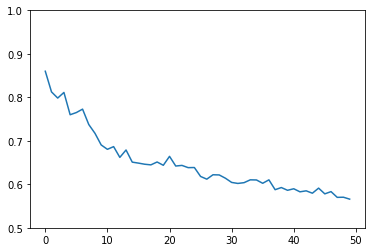

In [20]:
plt.plot(test_accuracies)
plt.ylim(ymin=0.5, ymax=1)
plt.show()

In [ ]:
DB1_test_accuracies = test_accuracies
%store DB1_test_accuracies

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()